<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1>1. Exploratory Data Analysis</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


<h2>1.1. Reading Data</h2>

<h3>1.1.1. Reading Gene and Variation Data</h3>

In [2]:
data = pd.read_csv('training_variants.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

<h3>1.1.2. Reading Text Data</h3>

In [3]:
# note the seprator in this file
data_text =pd.read_csv("training_text.csv",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

<h3>1.1.3. Preprocessing of text</h3>

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 58.349954288938285 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

In [7]:
result[result.isnull().any(axis=1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [9]:
result[result['ID']==1109]

ID   Gene Variation  Class          TEXT
1109  1109  FANCA    S1088F      1  FANCA S1088F

<h3>1.1.4. Test, Train and Cross Validation Split</h3>

<h4>1.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>1.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

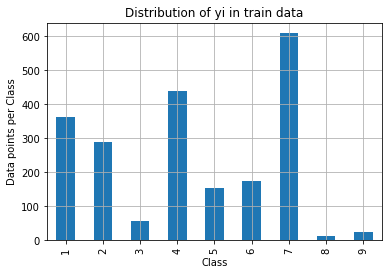

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


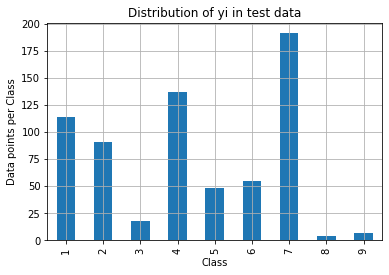

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


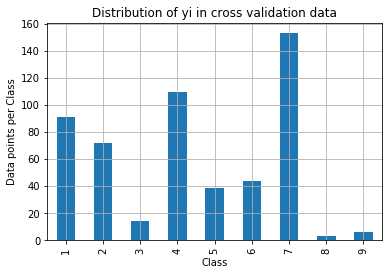

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [14]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


<h2>1.2 Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [11]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to rows and axis=1 corresponds to columns in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.533454592246902
Log loss on Test Data using Random Model 2.4349704675709414
-------------------- Confusion matrix --------------------


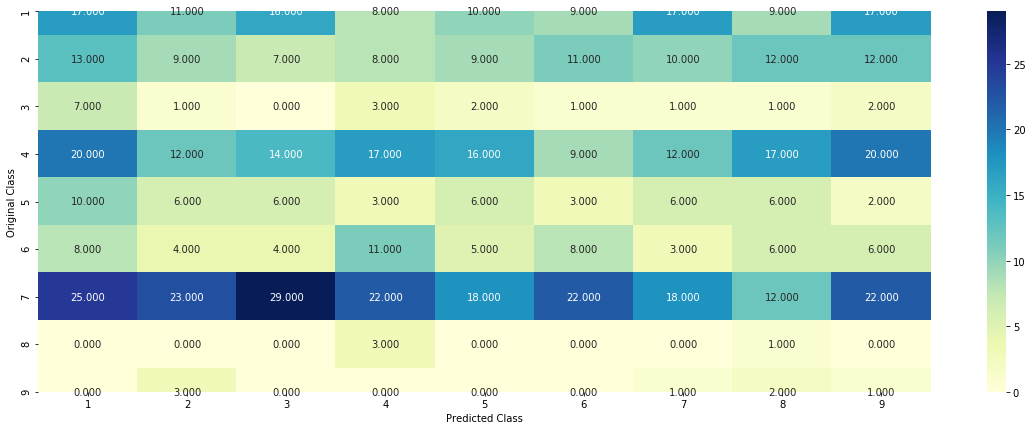

-------------------- Precision matrix (Columm Sum=1) --------------------


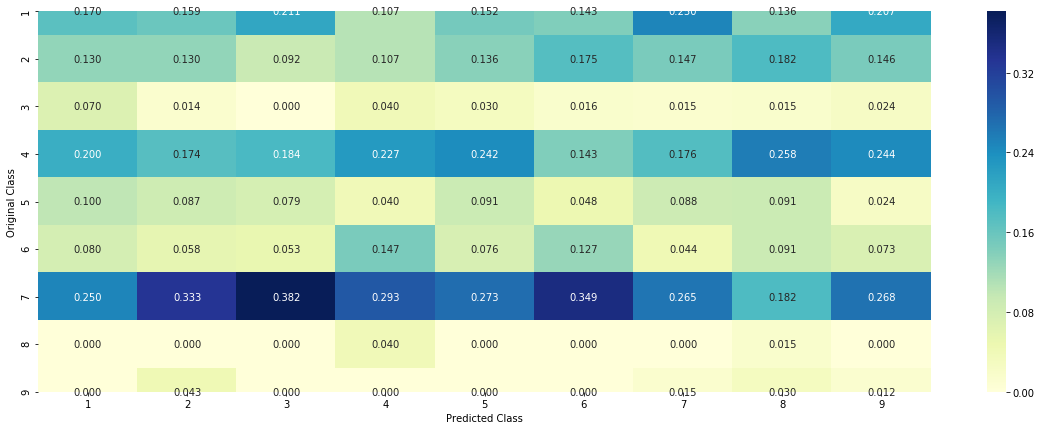

-------------------- Recall matrix (Row sum=1) --------------------


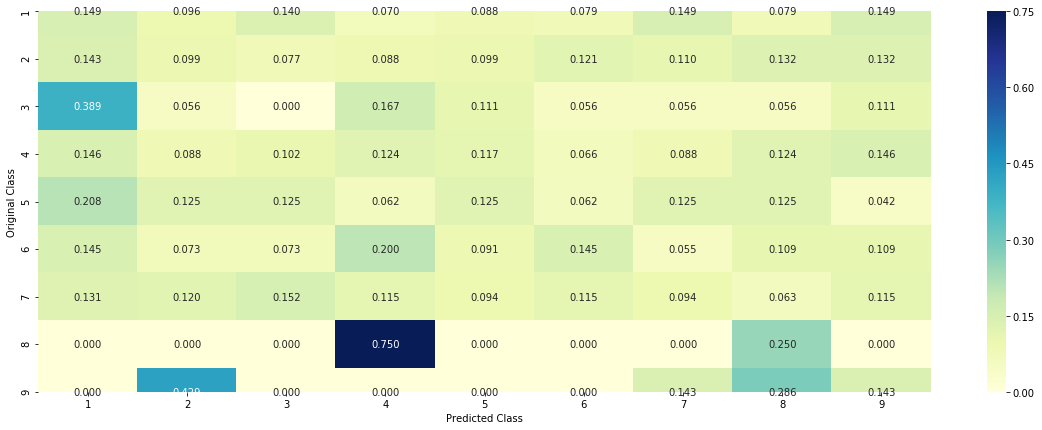

In [15]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h2>1.3 Univariate Analysis</h2>

In [12]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

<h3>1.2.1 Univariate Analysis on Gene Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [13]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 239
BRCA1     169
TP53      106
EGFR       94
BRCA2      82
PTEN       79
KIT        67
BRAF       56
ERBB2      49
ALK        49
PDGFRA     37
Name: Gene, dtype: int64


In [14]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 239 different categories of genes in the train data, and they are distibuted as follows


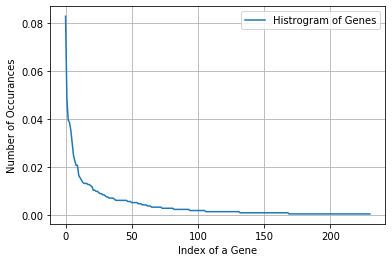

In [21]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


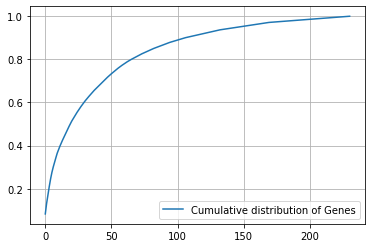

In [22]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [15]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [18]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [16]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [20]:
train_df['Gene'].head()

1089     MDM4
476      TP53
3172     RAF1
2739     BRAF
2776    BRCA2
Name: Gene, dtype: object

In [209]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'aurka',
 'aurkb',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 

In [21]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 229)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.2645158133401593
For values of alpha =  0.0001 The log loss is: 1.2505950294634163
For values of alpha =  0.001 The log loss is: 1.2758354849586095
For values of alpha =  0.01 The log loss is: 1.3439253791804318
For values of alpha =  0.1 The log loss is: 1.4369678904479162
For values of alpha =  1 The log loss is: 1.4838397311899596


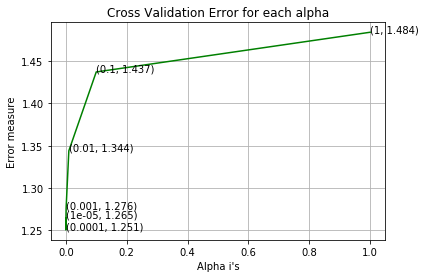

For values of best alpha =  0.0001 The train log loss is: 0.9920582250103623
For values of best alpha =  0.0001 The cross validation log loss is: 1.2505950294634163
For values of best alpha =  0.0001 The test log loss is: 1.19120635034831


In [211]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [82]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  231  genes in train dataset?
Ans
1. In test data 648 out of 665 : 97.44360902255639
2. In cross validation data 510 out of  532 : 95.86466165413535


<h3>3.2.2 Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [17]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1926
Truncating_Mutations    61
Deletion                48
Amplification           43
Fusions                 23
Overexpression           5
G12V                     3
T58I                     3
Q61H                     3
R170W                    2
Q61R                     2
Name: Variation, dtype: int64


In [18]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1927 different categories of variations in the train data, and they are distibuted as follows


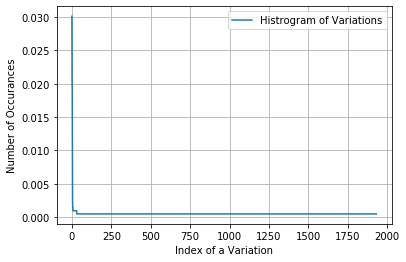

In [85]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.03013183 0.05084746 0.06967985 ... 0.99905838 0.99952919 1.        ]


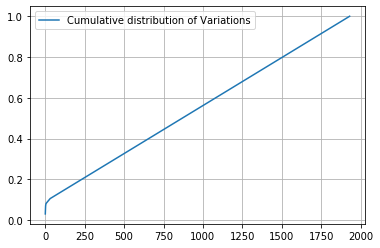

In [86]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [18]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [26]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [19]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [28]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1965)


<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.7254032294325496
For values of alpha =  0.0001 The log loss is: 1.7200628707938275
For values of alpha =  0.001 The log loss is: 1.7220952996649443
For values of alpha =  0.01 The log loss is: 1.7331615415847959
For values of alpha =  0.1 The log loss is: 1.7399510496061856
For values of alpha =  1 The log loss is: 1.7455212429880353


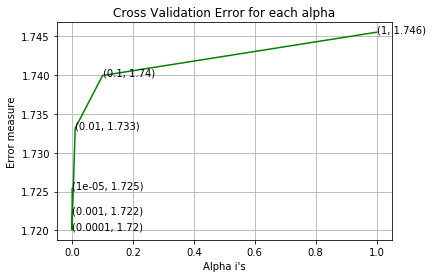

For values of best alpha =  0.0001 The train log loss is: 0.7666802522922677
For values of best alpha =  0.0001 The cross validation log loss is: 1.7200628707938275
For values of best alpha =  0.0001 The test log loss is: 1.6985905442394227


In [89]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [90]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1932  genes in test and cross validation data sets?
Ans
1. In test data 69 out of 665 : 10.37593984962406
2. In cross validation data 57 out of  532 : 10.714285714285714


<h3>3.2.3 Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [20]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [21]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [93]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52894


In [161]:
train_text_features[10050:10500]

['boat',
 'bodes',
 'bodies',
 'bodies13',
 'bodies16',
 'bodies17',
 'bodies43',
 'bodmer',
 'bodrug',
 'body',
 'boehm',
 'boehmer',
 'boehringer',
 'boer',
 'boggs5',
 'bogliolo',
 'boguski',
 'bohlander',
 'bohrer',
 'boi',
 'boice',
 'boiled',
 'boiling',
 'boils',
 'bok',
 'boland',
 'bold',
 'boldface',
 'bolero',
 'bolhuis',
 'bollag',
 'bolstad',
 'bolstering',
 'boltzmann',
 'bolus',
 'bomb',
 'bona',
 'bonafide',
 'bonaventure',
 'bond',
 'bonded',
 'bonding',
 'bonds',
 'bone',
 'bones',
 'bonferonni',
 'bonferroni',
 'bongarzone',
 'bonn',
 'bonnal',
 'bono',
 'bonus',
 'bony',
 'book',
 'bookmarking',
 'boon',
 'boop12',
 'boost',
 'boosted',
 'booster',
 'boosting',
 'boosts',
 'bootstrap',
 'bootstrapped',
 'bootstrapping',
 'bor',
 'boramae',
 'borate',
 'bordeaux',
 'border',
 'bordered',
 'bordering',
 'borderline',
 'borders',
 'bore',
 'boric',
 'bork',
 'born',
 'borne',
 'borohydrate',
 'borr',
 'borrello',
 'borrmann',
 'borrow',
 'bortezomib',
 'bortner',
 'bos

In [165]:
train_text_feature_onehotCoding.shape

(2124, 52894)

In [31]:
text_vectorizer_1k = TfidfVectorizer(max_features=1000)
train_text_feature_onehotCoding_1k = text_vectorizer_1k.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_1k= text_vectorizer_1k.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_1k = train_text_feature_onehotCoding_1k.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_1k = dict(zip(list(train_text_features_1k),train_text_fea_counts_1k))


print("Total number of unique words in train data :", len(train_text_features_1k))

Total number of unique words in train data : 1000


In [32]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

NameError: name 'train_text_features' is not defined

In [33]:
dict_list_1k = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_1k = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_1k.append(extract_dictionary_paddle(cls_text_1k))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_1k = extract_dictionary_paddle(train_df)


confuse_array_1k = []
for i in train_text_features_1k:
    ratios_1k = []
    max_val_1k = -1
    for j in range(0,9):
        ratios_1k.append((dict_list_1k[j][i]+10 )/(total_dict_1k[i]+90))
    confuse_array_1k.append(ratios_1k)
confuse_array_1k = np.array(confuse_array_1k)

In [95]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [96]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [97]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [34]:
train_text_feature_onehotCoding_1k = normalize(train_text_feature_onehotCoding_1k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_1k = text_vectorizer_1k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_1k = normalize(test_text_feature_onehotCoding_1k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_1k = text_vectorizer_1k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_1k = normalize(cv_text_feature_onehotCoding_1k, axis=0)

In [98]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [35]:
sorted_text_fea_dict_1k = dict(sorted(text_fea_dict_1k.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_1k = np.array(list(sorted_text_fea_dict_1k.values()))

In [99]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({0.02284712460210436: 316, 0.0410362626552918: 236, 0.011321380274379624: 230, 0.05270500549707009: 198, 0.02849878127395066: 165, 0.2613098949585787: 157, 0.02344438056187267: 142, 0.24021968471320534: 131, 0.062140440588087466: 125, 0.014897733504859217: 121, 0.042129716840164984: 109, 0.09353181669119083: 106, 0.0631819437853816: 103, 0.0560075877760301: 103, 0.010706948628939122: 103, 0.08824837456727941: 96, 0.04672781897601334: 95, 0.030628661006276314: 95, 0.01735105612158922: 95, 0.02691288965187489: 92, 0.029177457035484407: 87, 0.016176615660800635: 84, 0.012218519126937197: 83, 0.011288214008176409: 82, 0.038502759576793166: 73, 0.05831259758089715: 70, 0.06317699279499957: 69, 0.026162099983391272: 67, 0.02630150998953845: 66, 0.02154385465115741: 66, 0.014572741863297899: 65, 0.04463857182748693: 64, 0.015920338101308565: 64, 0.057153078712377736: 63, 0.15056378121626174: 62, 0.03092959343821137: 62, 0.03008561430045906: 62, 0.012165758224540628: 60, 0.077941113442

In [224]:
text_vectorizer_2k = TfidfVectorizer(max_features=2000)
train_text_feature_onehotCoding_2k = text_vectorizer_2k.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_2k= text_vectorizer_2k.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_2k = train_text_feature_onehotCoding_2k.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_2k = dict(zip(list(train_text_features_2k),train_text_fea_counts_2k))
print("Total number of unique words in train data :", len(train_text_features_2k))

Total number of unique words in train data : 2000


In [225]:
dict_list_2k = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_2k = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_2k.append(extract_dictionary_paddle(cls_text_2k))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_2k = extract_dictionary_paddle(train_df)


confuse_array_2k = []
for i in train_text_features_2k:
    ratios_2k = []
    max_val_2k = -1
    for j in range(0,9):
        ratios_2k.append((dict_list_2k[j][i]+10 )/(total_dict_2k[i]+90))
    confuse_array_2k.append(ratios_2k)
confuse_array_2k = np.array(confuse_array_2k)

In [226]:
# don't forget to normalize every feature
train_text_feature_onehotCoding_2k = normalize(train_text_feature_onehotCoding_2k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_2k = text_vectorizer_2k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_2k = normalize(test_text_feature_onehotCoding_2k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_2k = text_vectorizer_2k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_2k = normalize(cv_text_feature_onehotCoding_2k, axis=0)

In [227]:
sorted_text_fea_dict_2k = dict(sorted(text_fea_dict_2k.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_2k = np.array(list(sorted_text_fea_dict_2k.values()))

In [232]:
text_vectorizer_5k = TfidfVectorizer(max_features=5000)
train_text_feature_onehotCoding_5k = text_vectorizer_5k.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_5k= text_vectorizer_5k.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_5k = train_text_feature_onehotCoding_5k.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_5k = dict(zip(list(train_text_features_5k),train_text_fea_counts_5k))
print("Total number of unique words in train data :", len(train_text_features_5k))

Total number of unique words in train data : 5000


In [233]:
dict_list_5k = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_5k = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_5k.append(extract_dictionary_paddle(cls_text_5k))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_5k = extract_dictionary_paddle(train_df)


confuse_array_5k = []
for i in train_text_features_5k:
    ratios_5k = []
    max_val_5k = -1
    for j in range(0,9):
        ratios_5k.append((dict_list_5k[j][i]+10 )/(total_dict_5k[i]+90))
    confuse_array_5k.append(ratios_5k)
confuse_array_5k = np.array(confuse_array_5k)

In [234]:
# don't forget to normalize every feature
train_text_feature_onehotCoding_5k = normalize(train_text_feature_onehotCoding_5k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_5k = text_vectorizer_5k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_5k = normalize(test_text_feature_onehotCoding_5k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_5k = text_vectorizer_5k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_5k = normalize(cv_text_feature_onehotCoding_5k, axis=0)

In [235]:
sorted_text_fea_dict_5k = dict(sorted(text_fea_dict_5k.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_5k = np.array(list(sorted_text_fea_dict_5k.values()))

In [239]:
train_x_onehotCoding_5k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_5k)).tocsr()
train_y_5k = np.array(list(train_df['Class']))

test_x_onehotCoding_5k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_5k)).tocsr()
test_y_5k = np.array(list(test_df['Class']))

cv_x_onehotCoding_5k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_5k)).tocsr()
cv_y_5k = np.array(list(cv_df['Class']))

In [236]:
text_vectorizer_10k = TfidfVectorizer(max_features=10000)
train_text_feature_onehotCoding_10k = text_vectorizer_10k.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_10k= text_vectorizer_10k.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_10k = train_text_feature_onehotCoding_10k.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_10k = dict(zip(list(train_text_features_10k),train_text_fea_counts_10k))
print("Total number of unique words in train data :", len(train_text_features_10k))


dict_list_10k = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_10k = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_10k.append(extract_dictionary_paddle(cls_text_10k))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_10k = extract_dictionary_paddle(train_df)


confuse_array_10k = []
for i in train_text_features_10k:
    ratios_10k = []
    max_val_10k = -1
    for j in range(0,9):
        ratios_10k.append((dict_list_10k[j][i]+10 )/(total_dict_10k[i]+90))
    confuse_array_10k.append(ratios_10k)
confuse_array_10k = np.array(confuse_array_10k)


# don't forget to normalize every feature
train_text_feature_onehotCoding_10k = normalize(train_text_feature_onehotCoding_10k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_10k = text_vectorizer_10k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_10k = normalize(test_text_feature_onehotCoding_10k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_10k = text_vectorizer_10k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_10k = normalize(cv_text_feature_onehotCoding_10k, axis=0)


sorted_text_fea_dict_10k = dict(sorted(text_fea_dict_10k.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_10k = np.array(list(sorted_text_fea_dict_10k.values()))

Total number of unique words in train data : 10000


In [237]:
train_x_onehotCoding_10k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_10k)).tocsr()
train_y_10k = np.array(list(train_df['Class']))

test_x_onehotCoding_10k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_10k)).tocsr()
test_y_10k = np.array(list(test_df['Class']))

cv_x_onehotCoding_10k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_10k)).tocsr()
cv_y_10k = np.array(list(cv_df['Class']))

In [242]:
text_vectorizer_3k = TfidfVectorizer(max_features=3000)
train_text_feature_onehotCoding_3k = text_vectorizer_3k.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_3k= text_vectorizer_3k.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_3k = train_text_feature_onehotCoding_3k.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_3k = dict(zip(list(train_text_features_3k),train_text_fea_counts_3k))
print("Total number of unique words in train data :", len(train_text_features_3k))


dict_list_3k = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_3k = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_3k.append(extract_dictionary_paddle(cls_text_3k))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_3k = extract_dictionary_paddle(train_df)


confuse_array_3k = []
for i in train_text_features_3k:
    ratios_3k = []
    max_val_3k = -1
    for j in range(0,9):
        ratios_3k.append((dict_list_3k[j][i]+10 )/(total_dict_3k[i]+90))
    confuse_array_3k.append(ratios_3k)
confuse_array_3k = np.array(confuse_array_3k)


# don't forget to normalize every feature
train_text_feature_onehotCoding_3k = normalize(train_text_feature_onehotCoding_3k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_3k = text_vectorizer_3k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_3k = normalize(test_text_feature_onehotCoding_3k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_3k = text_vectorizer_3k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_3k = normalize(cv_text_feature_onehotCoding_3k, axis=0)


sorted_text_fea_dict_3k = dict(sorted(text_fea_dict_3k.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_3k = np.array(list(sorted_text_fea_dict_3k.values()))

Total number of unique words in train data : 3000


In [244]:
train_x_onehotCoding_3k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_3k)).tocsr()
train_y_3k = np.array(list(train_df['Class']))

test_x_onehotCoding_3k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_3k)).tocsr()
test_y_3k = np.array(list(test_df['Class']))

cv_x_onehotCoding_3k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_3k)).tocsr()
cv_y_3k = np.array(list(cv_df['Class']))

In [248]:
text_vectorizer_2_5k = TfidfVectorizer(max_features=2500)
train_text_feature_onehotCoding_2_5k = text_vectorizer_2_5k.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_2_5k= text_vectorizer_2_5k.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_2_5k = train_text_feature_onehotCoding_2_5k.sum(axis=0).A1#7

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_2_5k = dict(zip(list(train_text_features_2_5k),train_text_fea_counts_2_5k))
print("Total number of unique words in train data :", len(train_text_features_2_5k))


dict_list_2_5k = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_2_5k = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_2_5k.append(extract_dictionary_paddle(cls_text_2_5k))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_2_5k = extract_dictionary_paddle(train_df)


confuse_array_2_5k = []
for i in train_text_features_2_5k:
    ratios_2_5k = []
    max_val_2_5k = -1
    for j in range(0,9):
        ratios_2_5k.append((dict_list_2_5k[j][i]+10 )/(total_dict_2_5k[i]+90))
    confuse_array_2_5k.append(ratios_2_5k)
confuse_array_2_5k = np.array(confuse_array_2_5k)


# don't forget to normalize every feature
train_text_feature_onehotCoding_2_5k = normalize(train_text_feature_onehotCoding_2_5k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_2_5k = text_vectorizer_2_5k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_2_5k = normalize(test_text_feature_onehotCoding_2_5k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_2_5k = text_vectorizer_2_5k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_2_5k = normalize(cv_text_feature_onehotCoding_2_5k, axis=0)


sorted_text_fea_dict_2_5k = dict(sorted(text_fea_dict_2_5k.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_2_5k = np.array(list(sorted_text_fea_dict_2_5k.values()))

train_x_onehotCoding_2_5k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_2_5k)).tocsr()
train_y_2_5k = np.array(list(train_df['Class']))

test_x_onehotCoding_2_5k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_2_5k)).tocsr()
test_y_2_5k = np.array(list(test_df['Class']))

cv_x_onehotCoding_2_5k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_2_5k)).tocsr()
cv_y_2_5k = np.array(list(cv_df['Class']))

Total number of unique words in train data : 2500


In [31]:
text_vectorizer_2_8k = TfidfVectorizer(max_features=2800)
train_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_2_8k= text_vectorizer_2_8k.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_2_8k = train_text_feature_onehotCoding_2_8k.sum(axis=0).A1#7

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_2_8k = dict(zip(list(train_text_features_2_8k),train_text_fea_counts_2_8k))
print("Total number of unique words in train data :", len(train_text_features_2_8k))


dict_list_2_8k = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_2_8k = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_2_8k.append(extract_dictionary_paddle(cls_text_2_8k))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_2_8k = extract_dictionary_paddle(train_df)


confuse_array_2_8k = []
for i in train_text_features_2_8k:
    ratios_2_8k = []
    max_val_2_8k = -1
    for j in range(0,9):
        ratios_2_8k.append((dict_list_2_8k[j][i]+10 )/(total_dict_2_8k[i]+90))
    confuse_array_2_8k.append(ratios_2_8k)
confuse_array_2_8k = np.array(confuse_array_2_8k)


# don't forget to normalize every feature
train_text_feature_onehotCoding_2_8k = normalize(train_text_feature_onehotCoding_2_8k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_2_8k = normalize(test_text_feature_onehotCoding_2_8k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_2_8k = normalize(cv_text_feature_onehotCoding_2_8k, axis=0)


sorted_text_fea_dict_2_8k = dict(sorted(text_fea_dict_2_8k.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_2_8k = np.array(list(sorted_text_fea_dict_2_8k.values()))

train_x_onehotCoding_2_8k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_2_8k)).tocsr()
train_y_2_8k = np.array(list(train_df['Class']))

test_x_onehotCoding_2_8k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_2_8k)).tocsr()
test_y_2_8k = np.array(list(test_df['Class']))

cv_x_onehotCoding_2_8k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_2_8k)).tocsr()
cv_y_2_8k = np.array(list(cv_df['Class']))

Total number of unique words in train data : 2800


In [33]:
text_vectorizer_2_8k = CountVectorizer(max_features=2800,ngram_range=(1,4))
train_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_2_8k= text_vectorizer_2_8k.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_2_8k = train_text_feature_onehotCoding_2_8k.sum(axis=0).A1#7

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_2_8k = dict(zip(list(train_text_features_2_8k),train_text_fea_counts_2_8k))
print("Total number of unique words in train data :", len(train_text_features_2_8k))


dict_list_2_8k = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_2_8k = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_2_8k.append(extract_dictionary_paddle(cls_text_2_8k))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_2_8k = extract_dictionary_paddle(train_df)


confuse_array_2_8k = []
for i in train_text_features_2_8k:
    ratios_2_8k = []
    max_val_2_8k = -1
    for j in range(0,9):
        ratios_2_8k.append((dict_list_2_8k[j][i]+10 )/(total_dict_2_8k[i]+90))
    confuse_array_2_8k.append(ratios_2_8k)
confuse_array_2_8k = np.array(confuse_array_2_8k)


# don't forget to normalize every feature
train_text_feature_onehotCoding_2_8k = normalize(train_text_feature_onehotCoding_2_8k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_2_8k = normalize(test_text_feature_onehotCoding_2_8k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_2_8k = normalize(cv_text_feature_onehotCoding_2_8k, axis=0)


sorted_text_fea_dict_2_8k = dict(sorted(text_fea_dict_2_8k.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_2_8k = np.array(list(sorted_text_fea_dict_2_8k.values()))

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_2_8k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_2_8k)).tocsr()
train_y_2_8k = np.array(list(train_df['Class']))

test_x_onehotCoding_2_8k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_2_8k)).tocsr()
test_y_2_8k = np.array(list(test_df['Class']))

cv_x_onehotCoding_2_8k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_2_8k)).tocsr()
cv_y_2_8k = np.array(list(cv_df['Class']))

Total number of unique words in train data : 2800


In [ ]:
text_vectorizer_n_12_1k = TfidfVectorizer(max_features=780000,ngram_range=(1,2))
train_text_feature_onehotCoding_n_12_1k = text_vectorizer_n_12_1k.fit_transform(train_df['TEXT'])
train_text_feature_onehotCoding_n_12_1k = normalize(train_text_feature_onehotCoding_n_12_1k, axis=0)
# wetest_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_n_12_1k = text_vectorizer_n_12_1k.transform(test_df['TEXT'])

test_text_feature_onehotCoding_n_12_1k = normalize(test_text_feature_onehotCoding_n_12_1k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_n_12_1k = text_vectorizer_n_12_1k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_n_12_1k = normalize(cv_text_feature_onehotCoding_n_12_1k, axis=0)

train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=1000).fit(train_text_feature_onehotCoding_n_12_1k,train_y)
train_text_feature_onehotCoding_n_12_1k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_12_1k)
test_text_feature_onehotCoding_n_12_1k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_12_1k)
cv_text_feature_onehotCoding_n_12_1k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_12_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_12_1k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_12_1k_new)).tocsr()

test_x_onehotCoding_n_12_1k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_12_1k_new)).tocsr()

cv_x_onehotCoding_n_12_1k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_12_1k_new)).tocsr()


In [35]:
text_vectorizer_n_13_1k = TfidfVectorizer(max_features=780000,ngram_range=(1,3))
train_text_feature_onehotCoding_n_13_1k = text_vectorizer_n_13_1k.fit_transform(train_df['TEXT'])
train_text_feature_onehotCoding_n_13_1k = normalize(train_text_feature_onehotCoding_n_13_1k, axis=0)
# wetest_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_n_13_1k = text_vectorizer_n_13_1k.transform(test_df['TEXT'])

test_text_feature_onehotCoding_n_13_1k = normalize(test_text_feature_onehotCoding_n_13_1k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_n_13_1k = text_vectorizer_n_13_1k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_n_13_1k = normalize(cv_text_feature_onehotCoding_n_13_1k, axis=0)

train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=1000).fit(train_text_feature_onehotCoding_n_13_1k,train_y)
train_text_feature_onehotCoding_n_13_1k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_13_1k)
test_text_feature_onehotCoding_n_13_1k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_13_1k)
cv_text_feature_onehotCoding_n_13_1k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_13_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_13_1k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_13_1k_new)).tocsr()

test_x_onehotCoding_n_13_1k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_13_1k_new)).tocsr()

cv_x_onehotCoding_n_13_1k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_13_1k_new)).tocsr()


In [36]:
selectkbest1=SelectKBest(score_func=chi2,k=2000).fit(train_text_feature_onehotCoding_n_13_1k,train_y)
train_text_feature_onehotCoding_n_13_2k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_13_1k)
test_text_feature_onehotCoding_n_13_2k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_13_1k)
cv_text_feature_onehotCoding_n_13_2k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_13_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_13_2k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_13_2k_new)).tocsr()

test_x_onehotCoding_n_13_2k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_13_2k_new)).tocsr()

cv_x_onehotCoding_n_13_2k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_13_2k_new)).tocsr()


In [37]:
selectkbest1=SelectKBest(score_func=chi2,k=2000).fit(train_text_feature_onehotCoding_n_12_1k,train_y)
train_text_feature_onehotCoding_n_12_2k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_12_1k)
test_text_feature_onehotCoding_n_12_2k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_12_1k)
cv_text_feature_onehotCoding_n_12_2k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_12_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_12_2k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_12_2k_new)).tocsr()

test_x_onehotCoding_n_12_2k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_12_2k_new)).tocsr()

cv_x_onehotCoding_n_12_2k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_12_2k_new)).tocsr()


In [34]:
selectkbest1=SelectKBest(score_func=chi2,k=3000).fit(train_text_feature_onehotCoding_n_12_1k,train_y)
train_text_feature_onehotCoding_n_12_3k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_12_1k)
test_text_feature_onehotCoding_n_12_3k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_12_1k)
cv_text_feature_onehotCoding_n_12_3k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_12_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_12_3k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_12_3k_new)).tocsr()

test_x_onehotCoding_n_12_3k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_12_3k_new)).tocsr()

cv_x_onehotCoding_n_12_3k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_12_3k_new)).tocsr()


In [47]:
text_vectorizer_n_14_1k = TfidfVectorizer(max_features=780000,ngram_range=(1,4))
train_text_feature_onehotCoding_n_14_1k = text_vectorizer_n_14_1k.fit_transform(train_df['TEXT'])
train_text_feature_onehotCoding_n_14_1k = normalize(train_text_feature_onehotCoding_n_14_1k, axis=0)
# wetest_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_n_14_1k = text_vectorizer_n_14_1k.transform(test_df['TEXT'])

test_text_feature_onehotCoding_n_14_1k = normalize(test_text_feature_onehotCoding_n_14_1k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_n_14_1k = text_vectorizer_n_14_1k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_n_14_1k = normalize(cv_text_feature_onehotCoding_n_14_1k, axis=0)

train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=1000).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_1k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_1k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_1k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_1k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_1k_new)).tocsr()

test_x_onehotCoding_n_14_1k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_1k_new)).tocsr()

cv_x_onehotCoding_n_14_1k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_1k_new)).tocsr()


In [53]:
selectkbest1=SelectKBest(score_func=chi2,k=2000).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_2k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_2k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_2k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_2k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_2k_new)).tocsr()

test_x_onehotCoding_n_14_2k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_2k_new)).tocsr()

cv_x_onehotCoding_n_14_2k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_2k_new)).tocsr()


In [55]:
selectkbest1=SelectKBest(score_func=chi2,k=5000).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_5k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_5k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_5k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_5k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_5k_new)).tocsr()

test_x_onehotCoding_n_14_5k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_5k_new)).tocsr()

cv_x_onehotCoding_n_14_5k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_5k_new)).tocsr()


In [57]:
selectkbest1=SelectKBest(score_func=chi2,k=10000).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_10k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_10k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_10k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_10k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_10k_new)).tocsr()

test_x_onehotCoding_n_14_10k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_10k_new)).tocsr()

cv_x_onehotCoding_n_14_10k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_10k_new)).tocsr()


In [59]:
selectkbest1=SelectKBest(score_func=chi2,k=5500).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_55k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_55k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_55k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_55k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_55k_new)).tocsr()

test_x_onehotCoding_n_14_55k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_55k_new)).tocsr()

cv_x_onehotCoding_n_14_55k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_55k_new)).tocsr()


In [60]:
selectkbest1=SelectKBest(score_func=chi2,k=6000).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_6k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_6k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_6k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_6k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_6k_new)).tocsr()

test_x_onehotCoding_n_14_6k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_6k_new)).tocsr()

cv_x_onehotCoding_n_14_6k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_6k_new)).tocsr()


In [62]:
selectkbest1=SelectKBest(score_func=chi2,k=4000).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_4k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_4k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_4k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_4k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_4k_new)).tocsr()

test_x_onehotCoding_n_14_4k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_4k_new)).tocsr()

cv_x_onehotCoding_n_14_4k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_4k_new)).tocsr()


In [63]:
selectkbest1=SelectKBest(score_func=chi2,k=4500).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_45k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_45k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_45k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_45k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_45k_new)).tocsr()

test_x_onehotCoding_n_14_45k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_45k_new)).tocsr()

cv_x_onehotCoding_n_14_45k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_45k_new)).tocsr()


In [71]:
selectkbest1=SelectKBest(score_func=chi2,k=4800).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_48k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_48k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_48k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_48k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_48k_new)).tocsr()

test_x_onehotCoding_n_14_48k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_48k_new)).tocsr()

cv_x_onehotCoding_n_14_48k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_48k_new)).tocsr()


In [72]:
selectkbest1=SelectKBest(score_func=chi2,k=5200).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_52k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_52k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_52k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_52k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_52k_new)).tocsr()

test_x_onehotCoding_n_14_52k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_52k_new)).tocsr()

cv_x_onehotCoding_n_14_52k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_52k_new)).tocsr()


In [74]:
selectkbest1=SelectKBest(score_func=chi2,k=780000).fit(train_text_feature_onehotCoding_n_14_1k,train_y)
train_text_feature_onehotCoding_n_14_780k_new=selectkbest1.transform(train_text_feature_onehotCoding_n_14_1k)
test_text_feature_onehotCoding_n_14_780k_new=selectkbest1.transform(test_text_feature_onehotCoding_n_14_1k)
cv_text_feature_onehotCoding_n_14_780k_new=selectkbest1.transform(cv_text_feature_onehotCoding_n_14_1k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_n_14_780k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_n_14_780k_new)).tocsr()

test_x_onehotCoding_n_14_780k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_n_14_780k_new)).tocsr()

cv_x_onehotCoding_n_14_780k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_n_14_780k_new)).tocsr()


For values of alpha =  1e-05 The log loss is: 1.3682396329150364
For values of alpha =  0.0001 The log loss is: 1.2148887294229895
For values of alpha =  0.001 The log loss is: 1.2272753566434083
For values of alpha =  0.01 The log loss is: 1.2944259215134868
For values of alpha =  0.1 The log loss is: 1.3438757087026405
For values of alpha =  1 The log loss is: 1.591452332293722


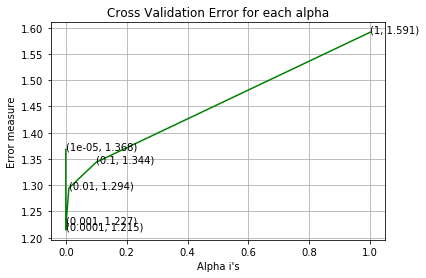

For values of best alpha =  0.0001 The train log loss is: 0.6413547784135093
For values of best alpha =  0.0001 The cross validation log loss is: 1.2148887294229895
For values of best alpha =  0.0001 The test log loss is: 1.1184964802556396


In [243]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [25]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

<h1>4. Machine Learning Models</h1>

In [26]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [27]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [28]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [106]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [41]:
train_gene_var_onehotCoding_1k = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding_1k = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding_1k = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_1k = hstack((train_gene_var_onehotCoding_1k, train_text_feature_onehotCoding_1k)).tocsr()
train_y_1k = np.array(list(train_df['Class']))

test_x_onehotCoding_1k = hstack((test_gene_var_onehotCoding_1k, test_text_feature_onehotCoding_1k)).tocsr()
test_y_1k = np.array(list(test_df['Class']))

cv_x_onehotCoding_1k = hstack((cv_gene_var_onehotCoding_1k, cv_text_feature_onehotCoding_1k)).tocsr()
cv_y_1k = np.array(list(cv_df['Class']))

In [229]:
train_gene_var_onehotCoding_2k = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding_2k = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding_2k = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_2k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_2k)).tocsr()
train_y_2k = np.array(list(train_df['Class']))

test_x_onehotCoding_2k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_2k)).tocsr()
test_y_2k = np.array(list(test_df['Class']))

cv_x_onehotCoding_2k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_2k)).tocsr()
cv_y_2k = np.array(list(cv_df['Class']))

In [107]:
print(train_gene_var_responseCoding.shape)
print(text_tfidf_train.shape)

(2124, 18)
(2124, 52894)


In [171]:
print(train_gene_var_responseCoding.shape)
print(train_x_onehotCoding_1k.shape)

(2124, 18)
(2124, 3191)


In [108]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55085)
(number of data points * number of features) in test data =  (665, 55085)
(number of data points * number of features) in cross validation data = (532, 55085)


In [109]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes</h3>

<h4>4.1.1.1. Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.3109041218026813
for alpha = 0.0001
Log Loss : 1.3076161356336862
for alpha = 0.001
Log Loss : 1.2948755693304796
for alpha = 0.1
Log Loss : 1.2981468820751327
for alpha = 1
Log Loss : 1.2898495144735644
for alpha = 10
Log Loss : 1.3604190579523876
for alpha = 100
Log Loss : 1.3027356949021838
for alpha = 1000
Log Loss : 1.284440878588116


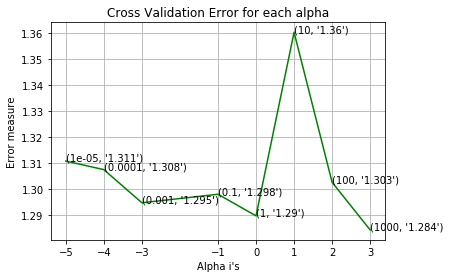

For values of best alpha =  1000 The train log loss is: 0.9149909726683924
For values of best alpha =  1000 The cross validation log loss is: 1.284440878588116
For values of best alpha =  1000 The test log loss is: 1.197765335090863


In [110]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>4.1.1.2. Testing the model with best hyper paramters</h4>

Log Loss : 1.284440878588116
Number of missclassified point : 0.42105263157894735
-------------------- Confusion matrix --------------------


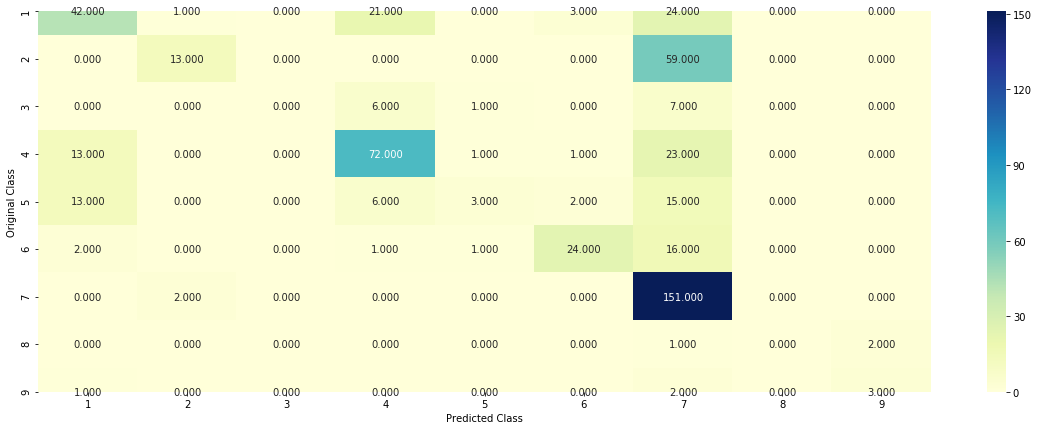

-------------------- Precision matrix (Columm Sum=1) --------------------


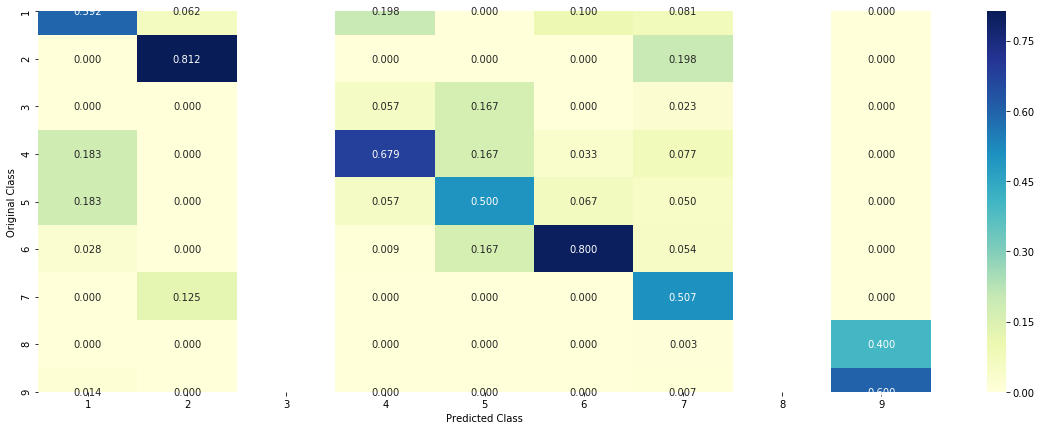

-------------------- Recall matrix (Row sum=1) --------------------


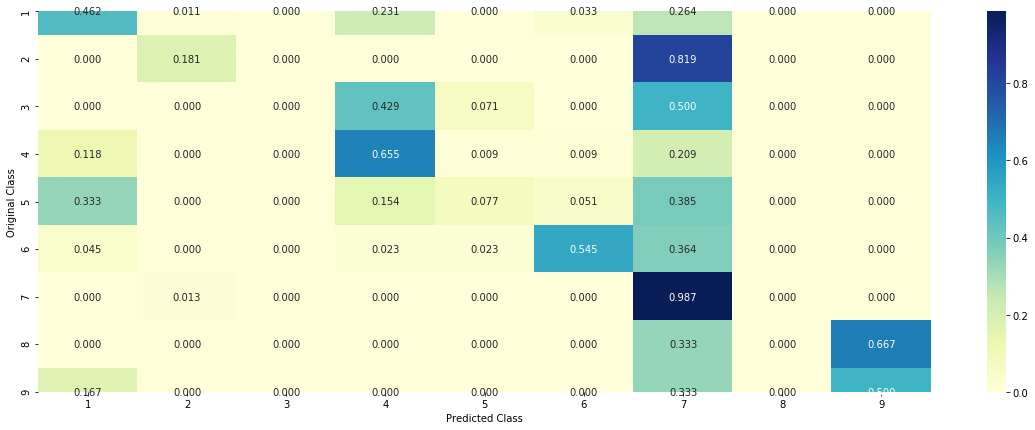

In [112]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding,train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding,train_y)
sig_clf_probs= sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<h4>4.1.1.3. Feature Importance, Correctly classified point</h4>

In [113]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[3.390e-02 4.570e-02 1.737e-01 3.640e-02 2.240e-02 2.000e-02 6.657e-01
  1.600e-03 6.000e-04]]
Actual Class : 7
--------------------------------------------------
16 Text feature [cells] present in test data point [True]
17 Text feature [cell] present in test data point [True]
18 Text feature [kinase] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [expressing] present in test data point [True]
21 Text feature [activated] present in test data point [True]
22 Text feature [activation] present in test data point [True]
23 Text feature [presence] present in test data point [True]
24 Text feature [inhibitor] present in test data point [True]
26 Text feature [contrast] present in test data point [True]
27 Text feature [signaling] present in test data point [True]
28 Text feature [phosphorylation] present in test data point [True]
29 Text feature [growth] present in test data 

<h4>4.1.1.4. Feature Importance, Incorrectly classified point</h4>

In [120]:
test_point_index = 5
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[7.300e-03 1.490e-02 6.000e-04 1.050e-02 8.500e-03 3.500e-03 9.544e-01
  2.000e-04 0.000e+00]]
Actual Class : 2
--------------------------------------------------
16 Text feature [cells] present in test data point [True]
17 Text feature [cell] present in test data point [True]
18 Text feature [kinase] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [expressing] present in test data point [True]
21 Text feature [activated] present in test data point [True]
22 Text feature [activation] present in test data point [True]
23 Text feature [presence] present in test data point [True]
24 Text feature [inhibitor] present in test data point [True]
25 Text feature [factor] present in test data point [True]
26 Text feature [contrast] present in test data point [True]
27 Text feature [signaling] present in test data point [True]
28 Text feature [phosphorylation] present in test data 

<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.1309170126692265
for alpha = 11
Log Loss : 1.1012397762291362
for alpha = 15
Log Loss : 1.1002748803755749
for alpha = 21
Log Loss : 1.1144110925957647
for alpha = 31
Log Loss : 1.1253206995500455
for alpha = 41
Log Loss : 1.1530939773909168
for alpha = 51
Log Loss : 1.1659585643007098
for alpha = 99
Log Loss : 1.1678505034822115


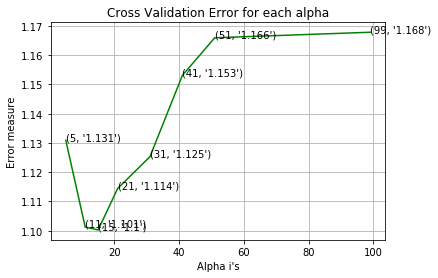

For values of best alpha =  15 The train log loss is: 0.7056892871225193
For values of best alpha =  15 The cross validation log loss is: 1.1002748803755749
For values of best alpha =  15 The test log loss is: 1.0911901980302394


In [0]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 1.1002748803755749
Number of mis-classified points : 0.3966165413533835
-------------------- Confusion matrix --------------------


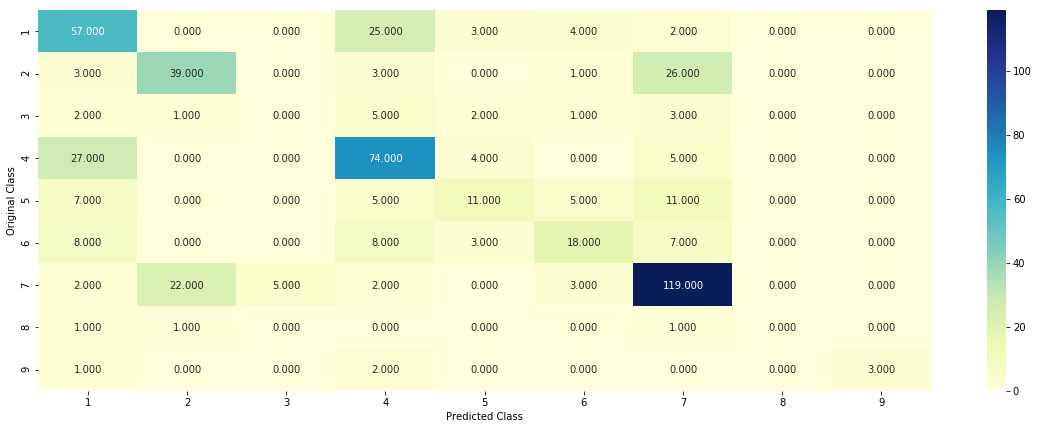

-------------------- Precision matrix (Columm Sum=1) --------------------


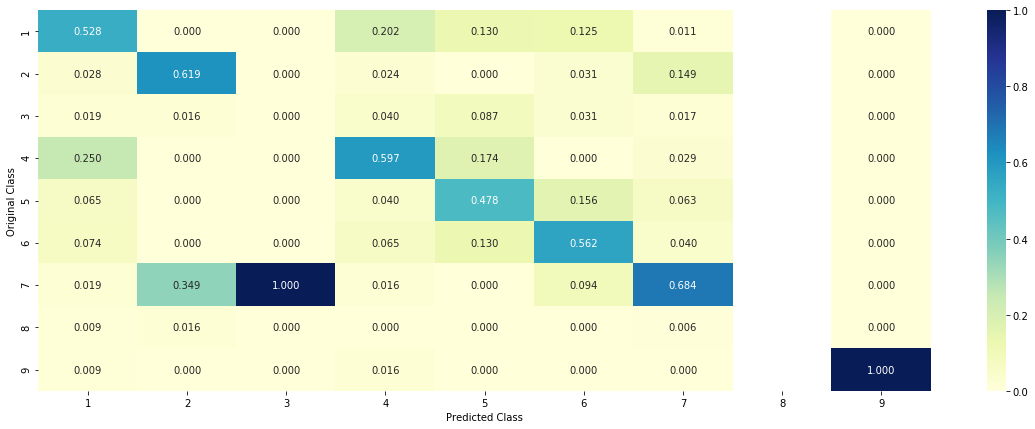

-------------------- Recall matrix (Row sum=1) --------------------


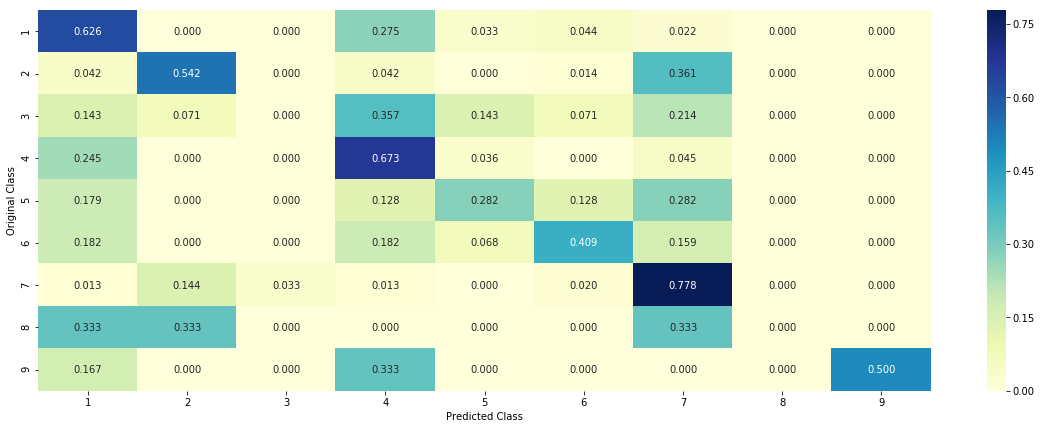

In [0]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

for alpha = 5
Log Loss : 1.2283896397739411
for alpha = 11
Log Loss : 1.2752773397276593
for alpha = 15
Log Loss : 1.2949077497874315
for alpha = 21
Log Loss : 1.30529177629646
for alpha = 31
Log Loss : 1.3214315180825738
for alpha = 41
Log Loss : 1.3346494159507396
for alpha = 51
Log Loss : 1.3637256844501835


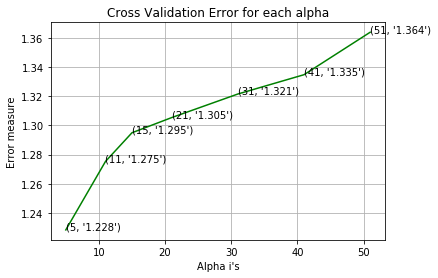

For values of best alpha =  5 The train log loss is: 0.9540263503861837
For values of best alpha =  5 The cross validation log loss is: 1.2283896397739411
For values of best alpha =  5 The test log loss is: 1.2080824125313825


In [74]:
alpha = [5, 11, 15, 21, 31, 41, 51]
cv_log_error_array_tfidf = []
for i in alpha:
    print("for alpha =", i)
    clf_tfidf = KNeighborsClassifier(n_neighbors=i)
    clf_tfidf.fit(text_tfidf_train, train_y)
    sig_clf_tfidf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
    sig_clf_tfidf.fit(text_tfidf_train, train_y)
    sig_clf_probs_tfidf = sig_clf_tfidf.predict_proba(text_tfidf_cv)
    cv_log_error_array_tfidf.append(log_loss(cv_y, sig_clf_probs_tfidf, labels=clf_tfidf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs_tfidf)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_tfidf,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_tfidf,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_tfidf[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_tfidf = np.argmin(cv_log_error_array_tfidf)
clf_tfidf = KNeighborsClassifier(n_neighbors=alpha[best_alpha_tfidf])
clf_tfidf.fit(text_tfidf_train, train_y)
sig_clf_tfidf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
sig_clf_tfidf.fit(text_tfidf_train, train_y)

predict_y_tfidf = sig_clf_tfidf.predict_proba(text_tfidf_train)
print('For values of best alpha = ', alpha[best_alpha_tfidf], "The train log loss is:",log_loss(y_train, predict_y_tfidf, labels=clf_tfidf.classes_, eps=1e-15))
predict_y_tfidf = sig_clf_tfidf.predict_proba(text_tfidf_cv)
print('For values of best alpha = ', alpha[best_alpha_tfidf], "The cross validation log loss is:",log_loss(y_cv, predict_y_tfidf, labels=clf_tfidf.classes_, eps=1e-15))
predict_y_tfidf = sig_clf_tfidf.predict_proba(text_tfidf_test)
print('For values of best alpha = ', alpha[best_alpha_tfidf], "The test log loss is:",log_loss(y_test, predict_y_tfidf, labels=clf_tfidf.classes_, eps=1e-15))

## Summary: KNN works best with response coding rather than with tf idf featurizer as we can see cv&test loss are more for tf idf featurizer than response coding

Log loss : 1.2283896397739411
Number of mis-classified points : 0.4323308270676692
-------------------- Confusion matrix --------------------


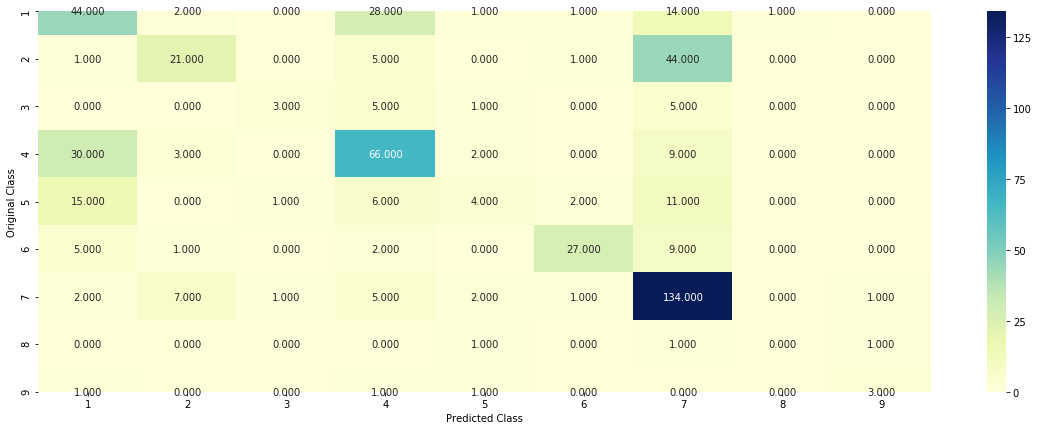

-------------------- Precision matrix (Columm Sum=1) --------------------


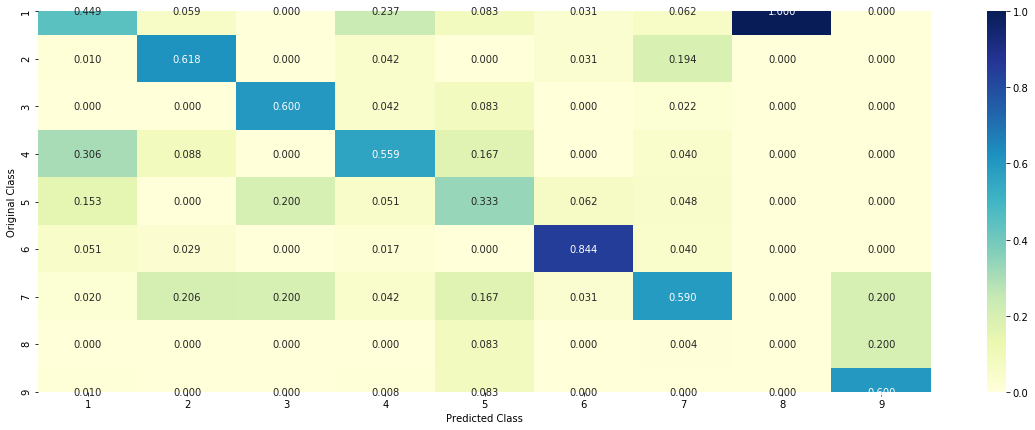

-------------------- Recall matrix (Row sum=1) --------------------


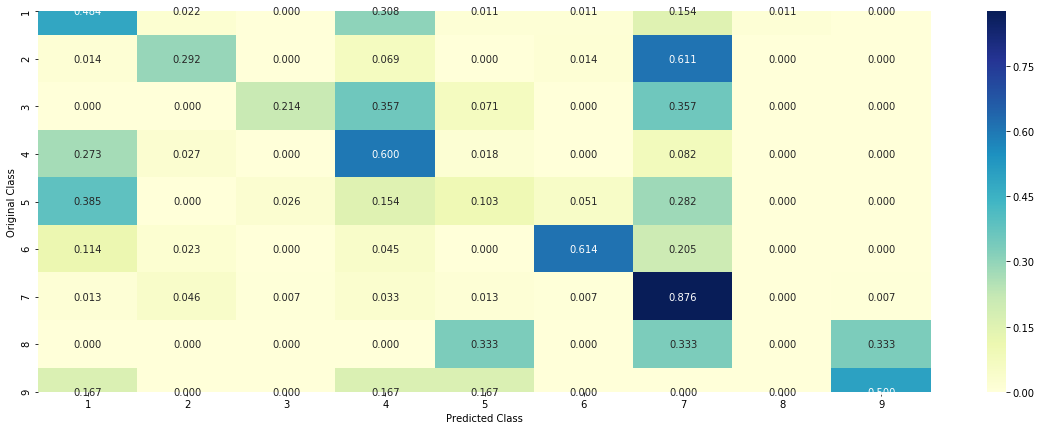

In [75]:
clf_tfidf = KNeighborsClassifier(n_neighbors=alpha[best_alpha_tfidf])
predict_and_plot_confusion_matrix(text_tfidf_train, train_y, text_tfidf_cv, cv_y, clf_tfidf)

<h3>4.2.3.Sample Query point -1</h3>

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 6
Actual Class : 7
The  15  nearest neighbours of the test points belongs to classes [7 7 7 6 6 7 6 7 6 7 7 7 7 7 6]
Fequency of nearest points : Counter({7: 10, 6: 5})


<h3>4.2.4. Sample Query Point-2 </h3>

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 15 and the nearest neighbours of the test points belongs to classes [2 7 5 7 7 2 7 7 7 2 7 7 7 7 7]
Fequency of nearest points : Counter({7: 11, 2: 3, 5: 1})


<h2>4.3. Logistic Regression</h2>

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.3677533665277744
for alpha = 1e-05
Log Loss : 1.3478972806511003
for alpha = 0.0001
Log Loss : 1.1684366825392198
for alpha = 0.001
Log Loss : 1.1537040638041502
for alpha = 0.01
Log Loss : 1.2022187699545805
for alpha = 0.1
Log Loss : 1.312922870982732
for alpha = 1
Log Loss : 1.4926057271957553
for alpha = 10
Log Loss : 1.5272192581206734
for alpha = 100
Log Loss : 1.53123344978271


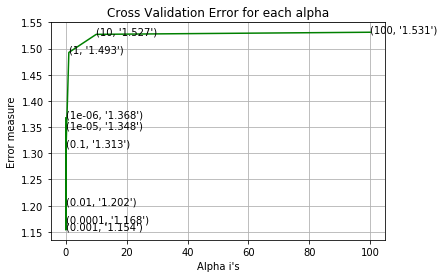

For values of best alpha =  0.001 The train log loss is: 0.5251770522525845
For values of best alpha =  0.001 The cross validation log loss is: 1.1537040638041502
For values of best alpha =  0.001 The test log loss is: 1.0476136461603704


In [121]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.1537040638041502
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


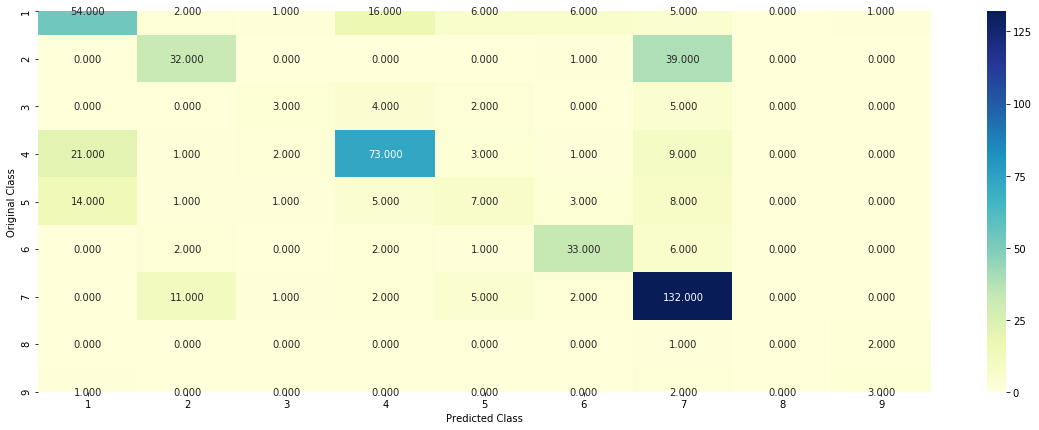

-------------------- Precision matrix (Columm Sum=1) --------------------


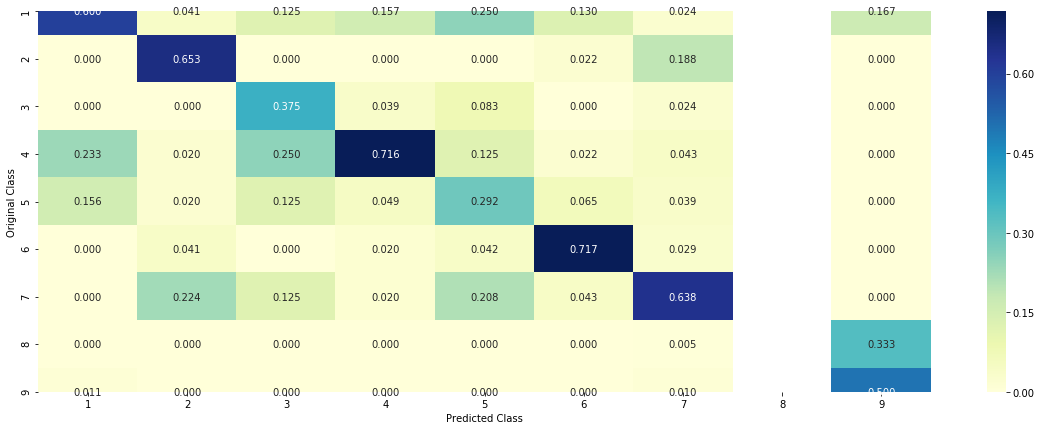

-------------------- Recall matrix (Row sum=1) --------------------


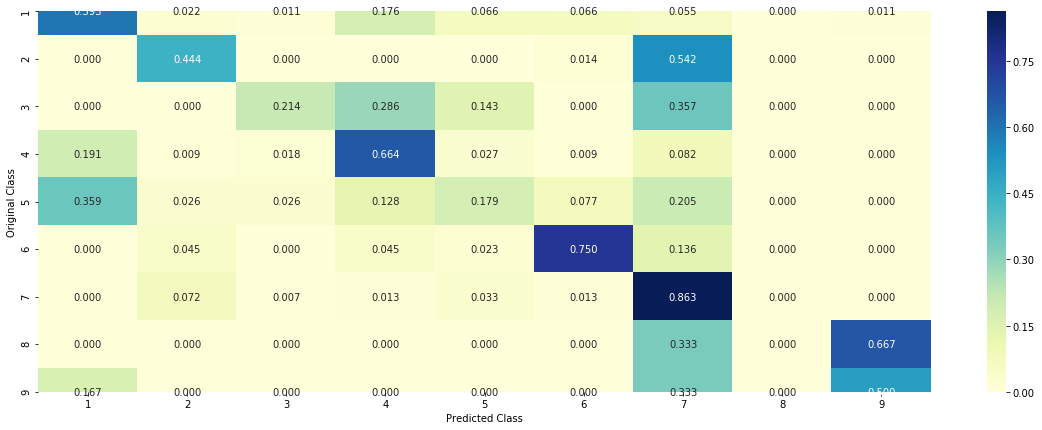

In [122]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>4.3.1.3. Feature Importance</h4>

In [29]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>4.3.1.3.1. InCorrectly Classified point</h5>

In [124]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[8.100e-03 1.640e-02 8.131e-01 5.900e-03 7.900e-03 3.300e-03 1.390e-01
  5.900e-03 5.000e-04]]
Actual Class : 7
--------------------------------------------------
162 Text feature [nonhematopoietic] present in test data point [True]
215 Text feature [soda] present in test data point [True]
229 Text feature [nontargeting] present in test data point [True]
230 Text feature [96aqueous] present in test data point [True]
231 Text feature [v592g] present in test data point [True]
232 Text feature [2293g] present in test data point [True]
233 Text feature [syampurnawati] present in test data point [True]
234 Text feature [1797a] present in test data point [True]
235 Text feature [d835insalg] present in test data point [True]
236 Text feature [levinson] present in test data point [True]
237 Text feature [2574g] present in test data point [True]
238 Text feature [d811] present in test data point [True]
239 Text feature [noncomplementary] prese

<h5>4.3.1.3.2. Correctly Classified point</h5>

In [125]:
test_point_index = 15
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[8.000e-04 4.400e-03 8.000e-04 6.000e-04 2.200e-03 8.000e-04 9.875e-01
  2.900e-03 0.000e+00]]
Actual Class : 7
--------------------------------------------------
20 Text feature [constitutive] present in test data point [True]
27 Text feature [activated] present in test data point [True]
30 Text feature [ligand] present in test data point [True]
33 Text feature [oncogene] present in test data point [True]
55 Text feature [egfrs] present in test data point [True]
66 Text feature [elicited] present in test data point [True]
72 Text feature [activation] present in test data point [True]
78 Text feature [phosphorylation] present in test data point [True]
80 Text feature [oncogenes] present in test data point [True]
85 Text feature [tyrosine] present in test data point [True]
86 Text feature [downstream] present in test data point [True]
105 Text feature [erk1] present in test data point [True]
109 Text feature [serum] present in test dat

<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.4056550095487015
for alpha = 1e-05
Log Loss : 1.3754659065296975
for alpha = 0.0001
Log Loss : 1.2373858450700739
for alpha = 0.001
Log Loss : 1.195491573603425
for alpha = 0.01
Log Loss : 1.2573375718630866
for alpha = 0.1
Log Loss : 1.2786196036869952
for alpha = 1
Log Loss : 1.4941486030220292


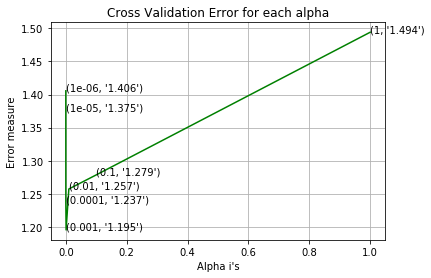

For values of best alpha =  0.001 The train log loss is: 0.5171397558143427
For values of best alpha =  0.001 The cross validation log loss is: 1.195491573603425
For values of best alpha =  0.001 The test log loss is: 1.059257297792163


In [126]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.195491573603425
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


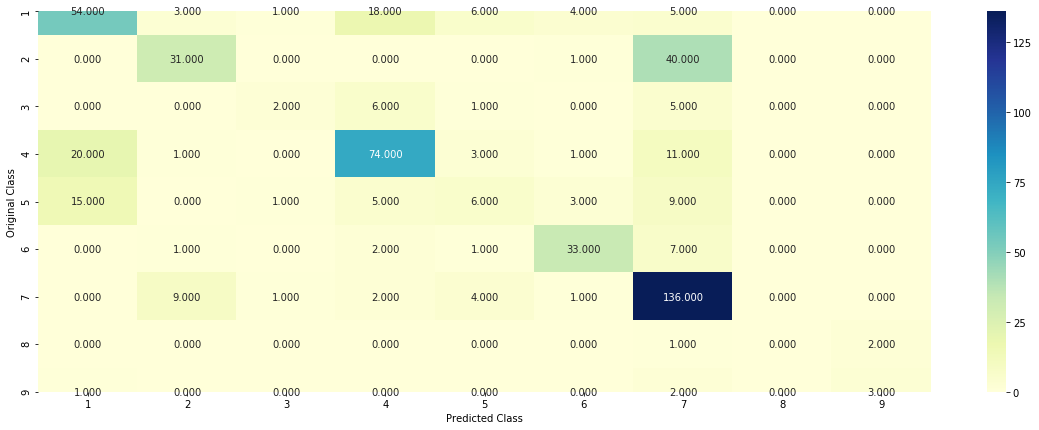

-------------------- Precision matrix (Columm Sum=1) --------------------


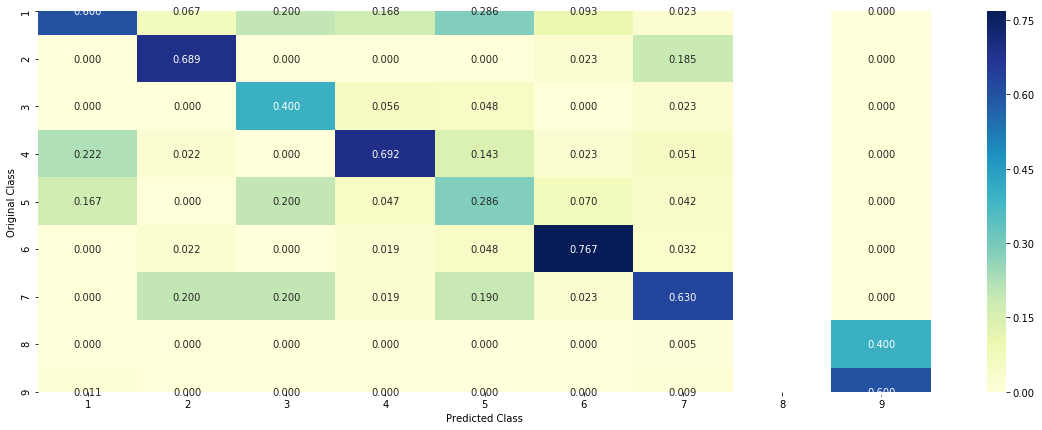

-------------------- Recall matrix (Row sum=1) --------------------


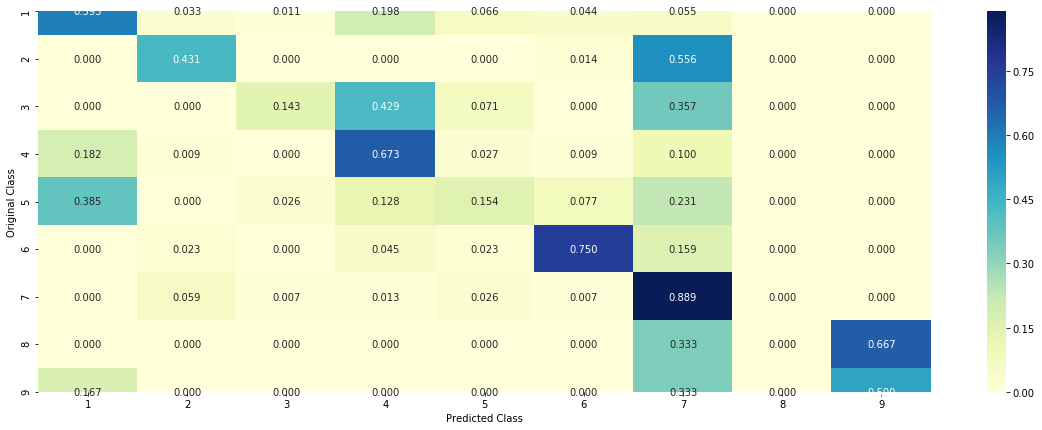

In [127]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>4.3.2.3. Feature Importance, InCorrectly Classified point</h4>

In [128]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[8.000e-03 1.540e-02 6.948e-01 6.100e-03 6.400e-03 2.700e-03 2.655e-01
  9.000e-04 1.000e-04]]
Actual Class : 7
--------------------------------------------------
210 Text feature [enst00000241453] present in test data point [True]
211 Text feature [bagrintseva] present in test data point [True]
212 Text feature [1797a] present in test data point [True]
213 Text feature [d324n] present in test data point [True]
214 Text feature [v592g] present in test data point [True]
215 Text feature [platanias] present in test data point [True]
216 Text feature [forrest] present in test data point [True]
217 Text feature [reindl] present in test data point [True]
218 Text feature [1172t] present in test data point [True]
219 Text feature [r834] present in test data point [True]
220 Text feature [v194m] present in test data point [True]
221 Text feature [n520y] present in test data point [True]
222 Text feature [2583g] present in test data point [Tr

<h4>4.3.2.4. Feature Importance, Correctly Classified point</h4>

In [129]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[2.000e-03 1.800e-03 2.000e-04 9.933e-01 1.000e-03 2.000e-04 1.400e-03
  1.000e-04 0.000e+00]]
Actual Class : 4
--------------------------------------------------
87 Text feature [2659] present in test data point [True]
171 Text feature [hartwell] present in test data point [True]
172 Text feature [suppressor] present in test data point [True]
206 Text feature [truncate] present in test data point [True]
232 Text feature [cosegregated] present in test data point [True]
242 Text feature [germline] present in test data point [True]
246 Text feature [material] present in test data point [True]
266 Text feature [hn] present in test data point [True]
347 Text feature [nonsense] present in test data point [True]
348 Text feature [carriers] present in test data point [True]
364 Text feature [1292] present in test data point [True]
399 Text feature [diploids] present in test data point [True]
Out of the top  500  features  12 are present in q

<h2>4.3. Logistic Regression_1k</h2>

for alpha = 1e-06
Log Loss : 1.1589260164436432
for alpha = 1e-05
Log Loss : 1.0521781868169495
for alpha = 0.0001
Log Loss : 1.004739480151319
for alpha = 0.001
Log Loss : 1.0142905615399844
for alpha = 0.01
Log Loss : 1.1458141030371896
for alpha = 0.1
Log Loss : 1.5902801330798502
for alpha = 1
Log Loss : 1.7319550422960648
for alpha = 10
Log Loss : 1.7484384841697544
for alpha = 100
Log Loss : 1.7503520206610756


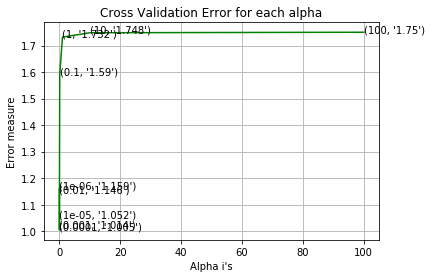

For values of best alpha =  0.0001 The train log loss is: 0.4400352056782639
For values of best alpha =  0.0001 The cross validation log loss is: 1.004739480151319
For values of best alpha =  0.0001 The test log loss is: 1.0119852430106584


In [43]:
from sklearn.metrics import log_loss
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_1k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_1k, train_y_1k)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_1k, train_y_1k)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_1k)
    cv_log_error_array_1k.append(log_loss(cv_y_1k, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y_1k, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_1k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_1k,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_1k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_1k = np.argmin(cv_log_error_array_1k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha_1k], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_1k, train_y_1k)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_1k, train_y_1k)

predict_y_1k = sig_clf.predict_proba(train_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha_1k], "The train log loss is:",log_loss(y_train, predict_y_1k, labels=clf.classes_, eps=1e-15))
predict_y_1k = sig_clf.predict_proba(cv_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha_1k], "The cross validation log loss is:",log_loss(y_cv, predict_y_1k, labels=clf.classes_, eps=1e-15))
predict_y_1k = sig_clf.predict_proba(test_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha_1k], "The test log loss is:",log_loss(y_test, predict_y_1k, labels=clf.classes_, eps=1e-15))

for alpha = 5e-05
Log Loss : 1.0074675940080606
for alpha = 8e-05
Log Loss : 1.0030787513902943
for alpha = 9e-05
Log Loss : 1.0035659764614224
for alpha = 0.0003
Log Loss : 1.0018664379820401
for alpha = 0.0005
Log Loss : 1.006006389397985
for alpha = 0.0008
Log Loss : 1.01184005255935


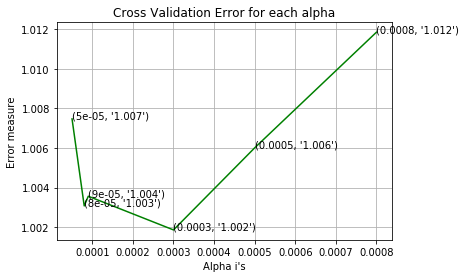

For values of best alpha =  0.0003 The train log loss is: 0.5381001962347631
For values of best alpha =  0.0003 The cross validation log loss is: 1.0018664379820401
For values of best alpha =  0.0003 The test log loss is: 1.0182451161694326


In [44]:
alpha = [0.00005,0.00008,0.00009,0.0003,0.0005,0.0008]
cv_log_error_array_1k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_1k, train_y_1k)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_1k, train_y_1k)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_1k)
    cv_log_error_array_1k.append(log_loss(cv_y_1k, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y_1k, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_1k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_1k,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_1k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_1k = np.argmin(cv_log_error_array_1k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha_1k], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_1k, train_y_1k)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_1k, train_y_1k)

predict_y_1k = sig_clf.predict_proba(train_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha_1k], "The train log loss is:",log_loss(y_train, predict_y_1k, labels=clf.classes_, eps=1e-15))
predict_y_1k = sig_clf.predict_proba(cv_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha_1k], "The cross validation log loss is:",log_loss(y_cv, predict_y_1k, labels=clf.classes_, eps=1e-15))
predict_y_1k = sig_clf.predict_proba(test_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha_1k], "The test log loss is:",log_loss(y_test, predict_y_1k, labels=clf.classes_, eps=1e-15))

Log loss : 1.060256256436125
Number of mis-classified points : 0.35902255639097747
-------------------- Confusion matrix --------------------


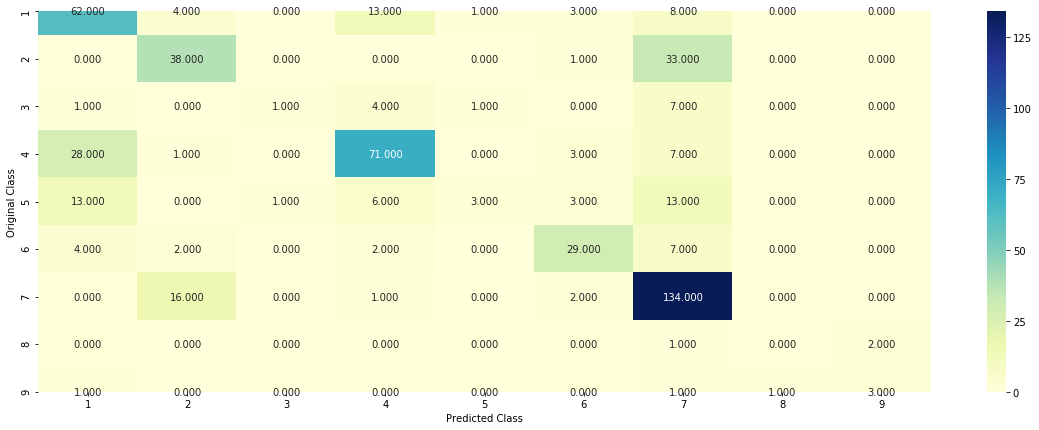

-------------------- Precision matrix (Columm Sum=1) --------------------


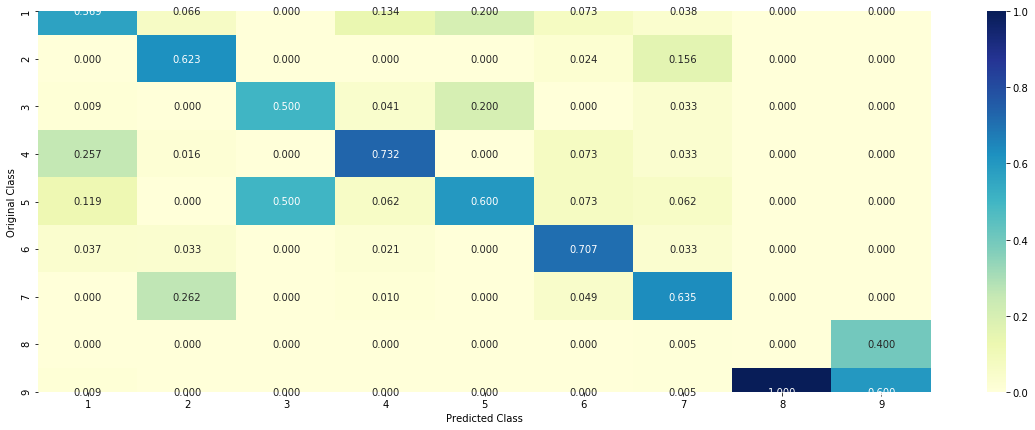

-------------------- Recall matrix (Row sum=1) --------------------


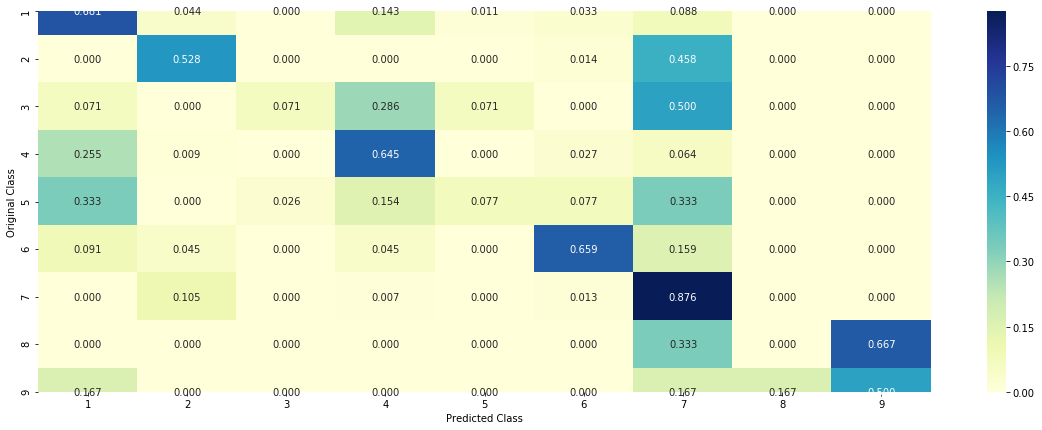

In [176]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha_1k], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_1k, train_y_1k, cv_x_onehotCoding_1k, cv_y_1k, clf)

<h4>Without Class balancing_1k</h4>

for alpha = 1e-06
Log Loss : 1.197905711258872
for alpha = 1e-05
Log Loss : 1.1217520182837826
for alpha = 0.0001
Log Loss : 1.0740885052641558
for alpha = 0.001
Log Loss : 1.1104225167838728
for alpha = 0.01
Log Loss : 1.2301435463967276
for alpha = 0.1
Log Loss : 1.4680309397481885
for alpha = 1
Log Loss : 1.582966085522831
for alpha = 10
Log Loss : 1.59751792211565
for alpha = 100
Log Loss : 1.5991335370669866


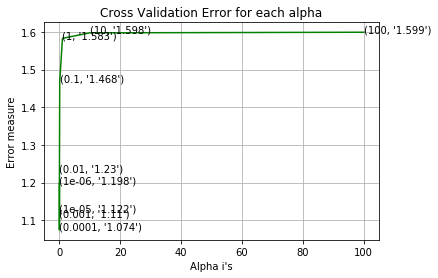

For values of best alpha =  0.0001 The train log loss is: 0.45519899732887625
For values of best alpha =  0.0001 The cross validation log loss is: 1.060256256436125
For values of best alpha =  0.0001 The test log loss is: 1.029493731632471


In [178]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_1k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_1k, train_y_1k)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_1k, train_y_1k)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_1k)
    cv_log_error_array_1k.append(log_loss(cv_y_1k, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y_1k, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_1k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_1k,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_1k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_1k = np.argmin(cv_log_error_array_1k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha_1k], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_1k, train_y_1k)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_1k, train_y_1k)

predict_y_1k = sig_clf.predict_proba(train_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha_1k], "The train log loss is:",log_loss(y_train, predict_y_1k, labels=clf.classes_, eps=1e-15))
predict_y_1k = sig_clf.predict_proba(cv_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha_1k], "The cross validation log loss is:",log_loss(y_cv, predict_y_1k, labels=clf.classes_, eps=1e-15))
predict_y_1k = sig_clf.predict_proba(test_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha_1k], "The test log loss is:",log_loss(y_test, predict_y_1k, labels=clf.classes_, eps=1e-15))

Log loss : 1.0740885052641558
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


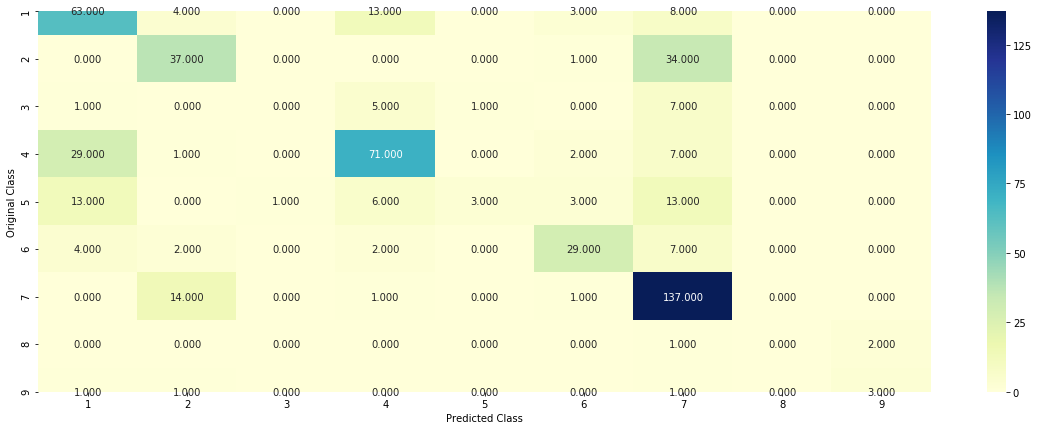

-------------------- Precision matrix (Columm Sum=1) --------------------


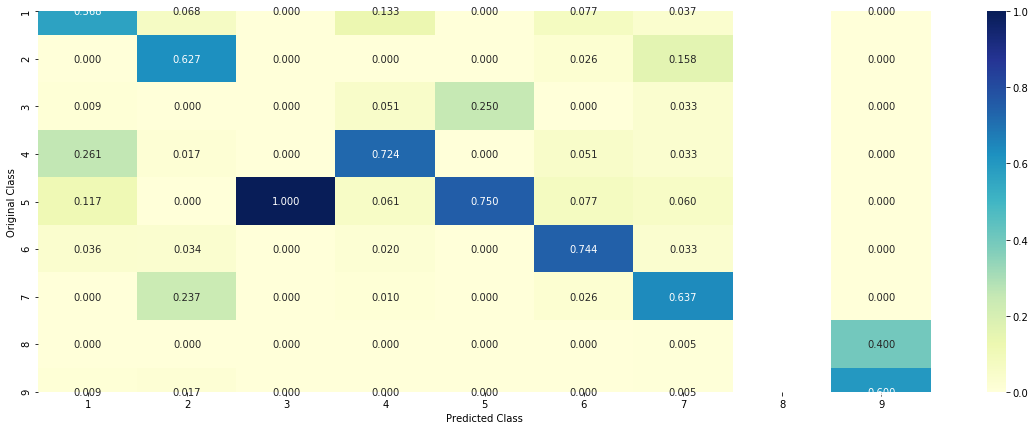

-------------------- Recall matrix (Row sum=1) --------------------


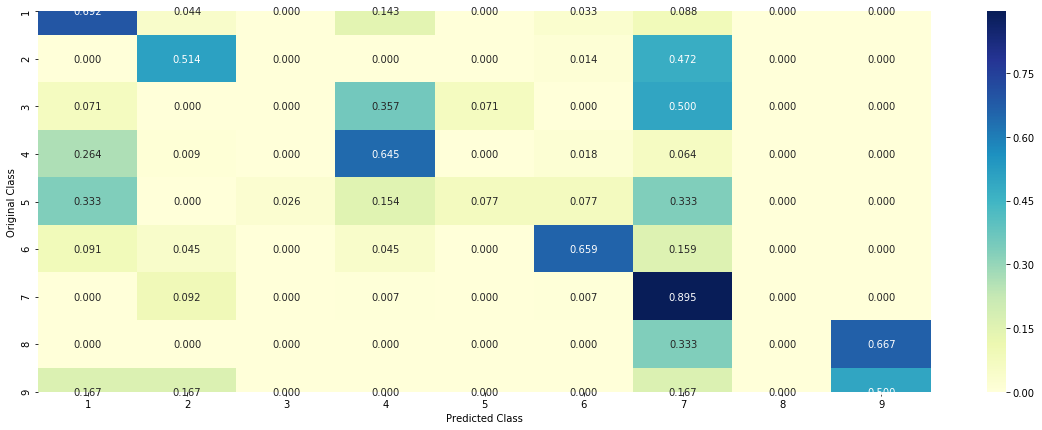

In [179]:
clf = SGDClassifier(alpha=alpha[best_alpha_1k], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding_1k, train_y_1k, cv_x_onehotCoding_1k, cv_y_1k, clf)

for alpha = 1e-06
Log Loss : 1.158649735146709
for alpha = 1e-05
Log Loss : 1.130810143946112
for alpha = 0.0001
Log Loss : 1.1057128870987551
for alpha = 0.001
Log Loss : 1.1310323329345793
for alpha = 0.01
Log Loss : 1.2316318413817822
for alpha = 0.1
Log Loss : 1.8021385044301144
for alpha = 1
Log Loss : 1.9306064460015233
for alpha = 10
Log Loss : 1.9415932549490058
for alpha = 100
Log Loss : 1.9427408049852655


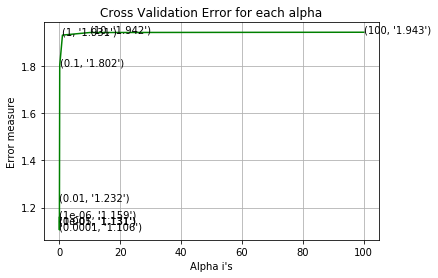

For values of best alpha =  0.0001 The train log loss is: 1.704293399472306
For values of best alpha =  0.0001 The cross validation log loss is: 1.9427408049852655
For values of best alpha =  0.0001 The test log loss is: 1.8508307336638512


In [230]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_2k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_2k, train_y_2k)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2k, train_y_2k)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2k)
    cv_log_error_array_2k.append(log_loss(cv_y_2k, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y_2k, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_2k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_2k,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_2k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_2k = np.argmin(cv_log_error_array_2k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha_1k], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_2k, train_y_2k)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2k, train_y_2k)

predict_y_2k = sig_clf.predict_proba(train_x_onehotCoding_2k)
print('For values of best alpha = ', alpha[best_alpha_2k], "The train log loss is:",log_loss(y_train, predict_y_2k, labels=clf.classes_, eps=1e-15))
predict_y_2k = sig_clf.predict_proba(cv_x_onehotCoding_2k)
print('For values of best alpha = ', alpha[best_alpha_2k], "The cross validation log loss is:",log_loss(y_cv, predict_y_2k, labels=clf.classes_, eps=1e-15))
predict_y_2k = sig_clf.predict_proba(test_x_onehotCoding_2k)
print('For values of best alpha = ', alpha[best_alpha_2k], "The test log loss is:",log_loss(y_test, predict_y_2k, labels=clf.classes_, eps=1e-15))

In [22]:
from sklearn.metrics import log_loss

In [23]:
text_vectorizer_3_8k = CountVectorizer(max_features=3800,ngram_range=(1,4))
train_text_feature_onehotCoding_3_8k = text_vectorizer_3_8k.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_3_8k= text_vectorizer_3_8k.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_3_8k = train_text_feature_onehotCoding_3_8k.sum(axis=0).A1#7

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_3_8k = dict(zip(list(train_text_features_3_8k),train_text_fea_counts_3_8k))
print("Total number of unique words in train data :", len(train_text_features_3_8k))


dict_list_3_8k = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_3_8k = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_3_8k.append(extract_dictionary_paddle(cls_text_3_8k))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_3_8k = extract_dictionary_paddle(train_df)


confuse_array_3_8k = []
for i in train_text_features_3_8k:
    ratios_3_8k = []
    max_val_3_8k = -1
    for j in range(0,9):
        ratios_3_8k.append((dict_list_3_8k[j][i]+10 )/(total_dict_3_8k[i]+90))
    confuse_array_3_8k.append(ratios_3_8k)
confuse_array_3_8k = np.array(confuse_array_3_8k)


# don't forget to normalize every feature
train_text_feature_onehotCoding_3_8k = normalize(train_text_feature_onehotCoding_3_8k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_3_8k = text_vectorizer_3_8k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_3_8k = normalize(test_text_feature_onehotCoding_3_8k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_3_8k = text_vectorizer_3_8k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_3_8k = normalize(cv_text_feature_onehotCoding_3_8k, axis=0)


sorted_text_fea_dict_3_8k = dict(sorted(text_fea_dict_3_8k.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_3_8k = np.array(list(sorted_text_fea_dict_3_8k.values()))

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_3_8k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_3_8k)).tocsr()
train_y_3_8k = np.array(list(train_df['Class']))

test_x_onehotCoding_3_8k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_3_8k)).tocsr()
test_y_3_8k = np.array(list(test_df['Class']))

cv_x_onehotCoding_3_8k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_3_8k)).tocsr()
cv_y_3_8k = np.array(list(cv_df['Class']))

Total number of unique words in train data : 3800


In [24]:
from sklearn.feature_selection import SelectKBest, chi2

In [26]:
text_vectorizer_2k = TfidfVectorizer(max_features=2013529,ngram_range=(1,4))
train_text_feature_onehotCoding_2k = text_vectorizer_2k.fit_transform(train_df['TEXT'])
# getting all the feature names (word
# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector

# zip(list(text_fea


# don't forget to normalize every feature
train_text_feature_onehotCoding_2k = normalize(train_text_feature_onehotCoding_2k, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_2k = text_vectorizer_2k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_2k = normalize(test_text_feature_onehotCoding_2k, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_2k = text_vectorizer_2k.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_2k = normalize(cv_text_feature_onehotCoding_2k, axis=0)

selectkbest1=SelectKBest(score_func=chi2,k=2800).fit(train_text_feature_onehotCoding_2k,train_y_3_8k)
train_text_feature_onehotCoding_2k_new=selectkbest1.transform(train_text_feature_onehotCoding_2k)
test_text_feature_onehotCoding_2k_new=selectkbest1.transform(test_text_feature_onehotCoding_2k)
cv_text_feature_onehotCoding_2k_new=selectkbest1.transform(cv_text_feature_onehotCoding_2k)


train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_2k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_2k)).tocsr()
train_y_2k = np.array(list(train_df['Class']))

test_x_onehotCoding_2k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_2k)).tocsr()
test_y_2k = np.array(list(test_df['Class']))

cv_x_onehotCoding_2k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_2k)).tocsr()
cv_y_2k = np.array(list(cv_df['Class']))

In [30]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [27]:
train_x_onehotCoding_2k_new = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_2k_new)).tocsr()
train_y_2k = np.array(list(train_df['Class']))

test_x_onehotCoding_2k_new = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_2k_new)).tocsr()
test_y_2k = np.array(list(test_df['Class']))

cv_x_onehotCoding_2k_new = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_2k_new)).tocsr()
cv_y_2k = np.array(list(cv_df['Class']))

for alpha = 1e-06
Log Loss : 1.4022108102241262
for alpha = 1e-05
Log Loss : 1.1591067820323229
for alpha = 0.0001
Log Loss : 1.10656532126473
for alpha = 0.001
Log Loss : 1.1354671624184378
for alpha = 0.01
Log Loss : 1.230883415090593
for alpha = 0.1
Log Loss : 1.3468606142833288
for alpha = 1
Log Loss : 1.379166382148769
for alpha = 10
Log Loss : 1.3902214088300862
for alpha = 100
Log Loss : 1.3919670937133621


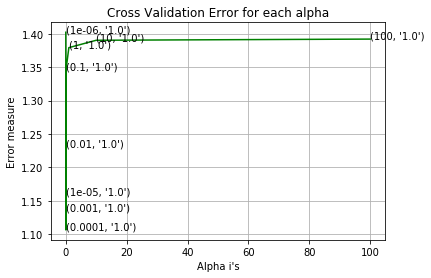

For values of best alpha =  0.0001 The train log loss is: 0.533251261042381
For values of best alpha =  0.0001 The cross validation log loss is: 1.10656532126473
For values of best alpha =  0.0001 The test log loss is: 1.1145512675587963


In [28]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100]
cv_log_error_array_2k_new=[]
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_2k_new, train_y_3_8k)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2k_new, train_y_3_8k)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2k_new)
    cv_log_error_array_2k_new.append(log_loss(cv_y_3_8k, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y_3_8k, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_2k_new,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_2k_new)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_2k_new[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_2k_new)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_2k_new, train_y_3_8k)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2k_new, train_y_3_8k)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_2k_new)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_2k_new)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_2k_new)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.1663915444437907
for alpha = 1e-05
Log Loss : 1.1407944363572524
for alpha = 0.0001
Log Loss : 1.0191958861498247
for alpha = 0.0005
Log Loss : 1.0163773270227905
for alpha = 0.0008
Log Loss : 1.040125217235296
for alpha = 0.001
Log Loss : 1.0494744776224951
for alpha = 0.002
Log Loss : 1.098376554880798
for alpha = 0.005
Log Loss : 1.1625860918294535
for alpha = 0.008
Log Loss : 1.230264653388373
for alpha = 0.01
Log Loss : 1.277850315234419
for alpha = 0.1
Log Loss : 1.8313552428231412
for alpha = 1
Log Loss : 1.862989647040027
for alpha = 10
Log Loss : 1.8643532966137546
for alpha = 100
Log Loss : 1.8644615111417147


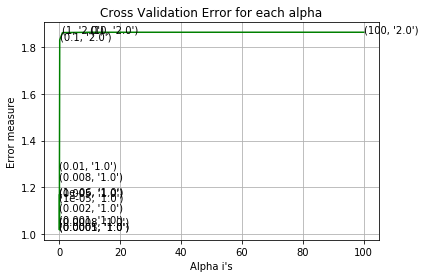

For values of best alpha =  0.0005 The train log loss is: 0.5546523203921462
For values of best alpha =  0.0005 The cross validation log loss is: 1.0163773270227905
For values of best alpha =  0.0005 The test log loss is: 1.0637090289612432


In [27]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [0.000001,0.00001,0.0001,0.0005,0.0008,0.001,0.002,0.005,0.008,0.01,0.1,1,10,100]
cv_log_error_array_3_8k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_3_8k, train_y_3_8k)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_3_8k, train_y_3_8k)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_3_8k)
    cv_log_error_array_3_8k.append(log_loss(cv_y_3_8k, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y_3_8k, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_3_8k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_3_8k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_3_8k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_3_8k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_3_8k, train_y_3_8k)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_3_8k, train_y_3_8k)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_3_8k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_3_8k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_3_8k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.3767361593798655
for alpha = 1e-05
Log Loss : 1.1617418358529417
for alpha = 0.0001
Log Loss : 1.0953167203189076
for alpha = 0.001
Log Loss : 1.1485393781686566
for alpha = 0.01
Log Loss : 1.2675600914100824
for alpha = 0.1
Log Loss : 1.3849590754195338
for alpha = 1
Log Loss : 1.419841523668523
for alpha = 10
Log Loss : 1.4258062530179132
for alpha = 100
Log Loss : 1.426584520798404


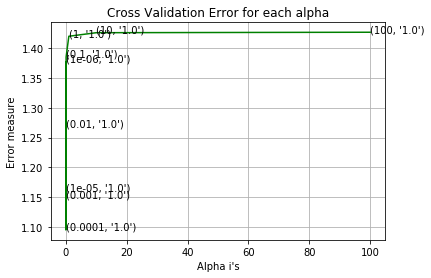

For values of best alpha =  0.0001 The train log loss is: 0.5189777979767733
For values of best alpha =  0.0001 The cross validation log loss is: 1.0953167203189076
For values of best alpha =  0.0001 The test log loss is: 1.108374793586933


In [30]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_12_1k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_12_1k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_12_1k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_12_1k)
    cv_log_error_array_n_12_1k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_12_1k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_12_1k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_12_1k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_12_1k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_12_1k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_12_1k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_12_1k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_12_1k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_12_1k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.3964295099316328
for alpha = 1e-05
Log Loss : 1.162307915671898
for alpha = 0.0001
Log Loss : 1.0940150746343498
for alpha = 0.001
Log Loss : 1.1462638853009885
for alpha = 0.01
Log Loss : 1.2649957587643612
for alpha = 0.1
Log Loss : 1.381382027492919
for alpha = 1
Log Loss : 1.4169701854091028
for alpha = 10
Log Loss : 1.4234381468288444
for alpha = 100
Log Loss : 1.424294738963977


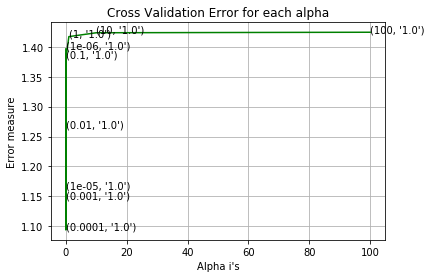

For values of best alpha =  0.0001 The train log loss is: 0.5214851545434706
For values of best alpha =  0.0001 The cross validation log loss is: 1.0940150746343498
For values of best alpha =  0.0001 The test log loss is: 1.1087525199034607


In [38]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_12_2k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_12_2k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_12_2k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_12_2k)
    cv_log_error_array_n_12_2k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_12_2k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_12_2k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_12_2k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_12_2k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_12_2k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_12_2k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_12_2k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_12_2k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_12_2k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.397725072594626
for alpha = 1e-05
Log Loss : 1.1631996997839602
for alpha = 0.0001
Log Loss : 1.09373186215201
for alpha = 0.001
Log Loss : 1.146315890601235
for alpha = 0.01
Log Loss : 1.2650238905969815
for alpha = 0.1
Log Loss : 1.3816497706336188
for alpha = 1
Log Loss : 1.4180673730665392
for alpha = 10
Log Loss : 1.4256888493631896
for alpha = 100
Log Loss : 1.4257804239488339


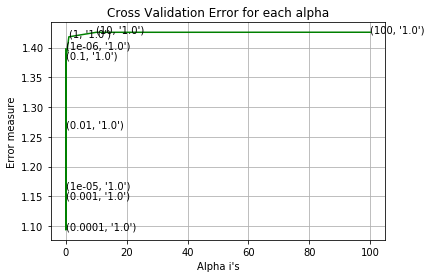

For values of best alpha =  0.0001 The train log loss is: 0.5213443664070709
For values of best alpha =  0.0001 The cross validation log loss is: 1.09373186215201
For values of best alpha =  0.0001 The test log loss is: 1.1083780501366376


In [39]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_12_3k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_12_3k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_12_3k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_12_3k)
    cv_log_error_array_n_12_3k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_12_3k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_12_3k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_12_3k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_12_3k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_12_3k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_12_3k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_12_3k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_12_3k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_12_3k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.397860320294552
for alpha = 1e-05
Log Loss : 1.1627470847543804
for alpha = 0.0001
Log Loss : 1.0995334611852086
for alpha = 0.001
Log Loss : 1.1503629756570484
for alpha = 0.01
Log Loss : 1.2674304826104683
for alpha = 0.1
Log Loss : 1.3851870947434555
for alpha = 1
Log Loss : 1.4206259465696243
for alpha = 10
Log Loss : 1.4268983982896042
for alpha = 100
Log Loss : 1.4276948238777791


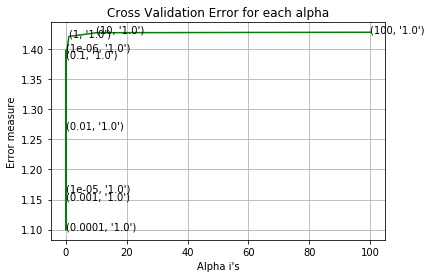

For values of best alpha =  0.0001 The train log loss is: 0.5254541697603193
For values of best alpha =  0.0001 The cross validation log loss is: 1.0995334611852086
For values of best alpha =  0.0001 The test log loss is: 1.1074848380161042


In [40]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_13_1k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_13_1k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_13_1k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_13_1k)
    cv_log_error_array_n_13_1k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_13_1k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_13_1k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_13_1k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_13_1k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_13_1k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_13_1k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_13_1k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_13_1k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_13_1k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.3964448474913247
for alpha = 1e-05
Log Loss : 1.1598508750574361
for alpha = 0.0001
Log Loss : 1.0991546278460311
for alpha = 0.001
Log Loss : 1.150567608620956
for alpha = 0.01
Log Loss : 1.2665479225646823
for alpha = 0.1
Log Loss : 1.3840199099352333
for alpha = 1
Log Loss : 1.4258811677626708
for alpha = 10
Log Loss : 1.4329285140119656
for alpha = 100
Log Loss : 1.4337884899142253


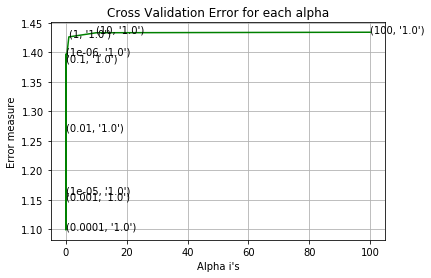

For values of best alpha =  0.0001 The train log loss is: 0.5311670111940074
For values of best alpha =  0.0001 The cross validation log loss is: 1.0991546278460311
For values of best alpha =  0.0001 The test log loss is: 1.1047426833337077


In [41]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_13_2k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_13_2k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_13_2k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_13_2k)
    cv_log_error_array_n_13_2k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_13_2k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_13_2k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_13_2k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_13_2k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_13_2k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_13_2k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_13_2k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_13_2k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_13_2k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.3943710589864842
for alpha = 1e-05
Log Loss : 1.1650312171769739
for alpha = 0.0001
Log Loss : 1.109076913631957
for alpha = 0.001
Log Loss : 1.123898619791195
for alpha = 0.01
Log Loss : 1.2084169305861054
for alpha = 0.1
Log Loss : 1.3351268827684089
for alpha = 1
Log Loss : 1.3888274329066908
for alpha = 10
Log Loss : 1.3984443172361214
for alpha = 100
Log Loss : 1.3996544012840917


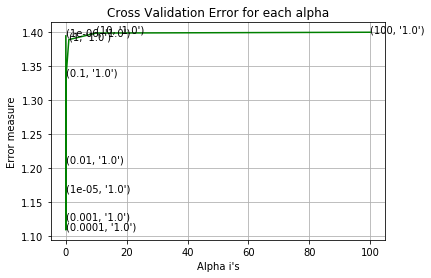

For values of best alpha =  0.0001 The train log loss is: 0.5210109200576049
For values of best alpha =  0.0001 The cross validation log loss is: 1.109076913631957
For values of best alpha =  0.0001 The test log loss is: 1.1206783495323411


In [49]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_14_1k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_1k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_1k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_1k)
    cv_log_error_array_n_14_1k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_1k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_1k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_1k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_1k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_1k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_1k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_1k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_1k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_1k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.3841400424598402
for alpha = 1e-05
Log Loss : 1.1622673900775393
for alpha = 0.0001
Log Loss : 1.106594805475711
for alpha = 0.001
Log Loss : 1.1245937229405092
for alpha = 0.01
Log Loss : 1.2111727274301747
for alpha = 0.1
Log Loss : 1.3375906540786147
for alpha = 1
Log Loss : 1.388298982007952
for alpha = 10
Log Loss : 1.397923623608382
for alpha = 100
Log Loss : 1.3991712697851972


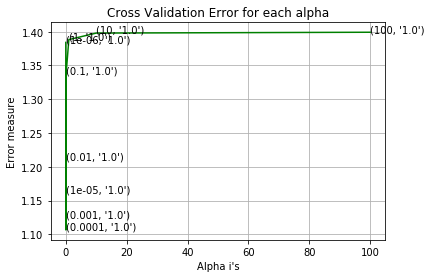

For values of best alpha =  0.0001 The train log loss is: 0.5200144439464987
For values of best alpha =  0.0001 The cross validation log loss is: 1.106594805475711
For values of best alpha =  0.0001 The test log loss is: 1.1158812962278863


In [54]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_14_2k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_2k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_2k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_2k)
    cv_log_error_array_n_14_2k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_2k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_2k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_2k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_2k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_2k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_2k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_2k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_2k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_2k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.4448332624562097
for alpha = 1e-05
Log Loss : 1.185240536415651
for alpha = 0.0001
Log Loss : 1.0458160151271556
for alpha = 0.001
Log Loss : 1.0801937529582772
for alpha = 0.01
Log Loss : 1.195209137316661
for alpha = 0.1
Log Loss : 1.3359639452563374
for alpha = 1
Log Loss : 1.3975599536581904
for alpha = 10
Log Loss : 1.4074715999843515
for alpha = 100
Log Loss : 1.40863482129484


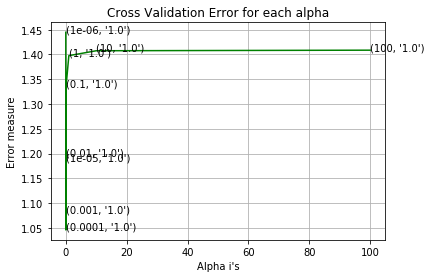

For values of best alpha =  0.0001 The train log loss is: 0.4623134687432315
For values of best alpha =  0.0001 The cross validation log loss is: 1.0458160151271556
For values of best alpha =  0.0001 The test log loss is: 1.0399815797429028


In [56]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_14_5k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_5k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_5k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_5k)
    cv_log_error_array_n_14_5k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_5k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_5k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_5k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_5k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_5k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_5k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_5k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_5k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_5k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 9e-05
Log Loss : 1.0463685597190842
for alpha = 0.0001
Log Loss : 1.0458160151271556
for alpha = 0.00015
Log Loss : 1.0440822462691186
for alpha = 0.00018
Log Loss : 1.0461182600616192


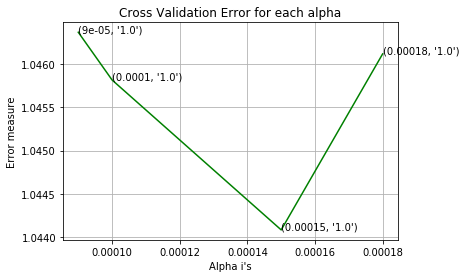

For values of best alpha =  0.00015 The train log loss is: 0.49046342416028244
For values of best alpha =  0.00015 The cross validation log loss is: 1.0440822462691186
For values of best alpha =  0.00015 The test log loss is: 1.036025430757726


In [69]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [0.00009,0.0001,0.00015,0.00018]
cv_log_error_array_n_14_5k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_5k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_5k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_5k)
    cv_log_error_array_n_14_5k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_5k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_5k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_5k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_5k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_5k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_5k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_5k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_5k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_5k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.4477139129102776
for alpha = 1e-05
Log Loss : 1.2462601233073392
for alpha = 0.0001
Log Loss : 1.083389177180829
for alpha = 0.001
Log Loss : 1.0875762225713403
for alpha = 0.01
Log Loss : 1.2265155186665755
for alpha = 0.1
Log Loss : 1.4302208409232928
for alpha = 1
Log Loss : 1.5499133474337101
for alpha = 10
Log Loss : 1.5568128723194934
for alpha = 100
Log Loss : 1.5541974106584886


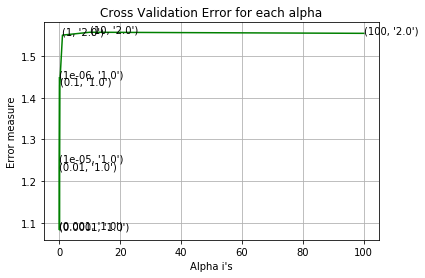

For values of best alpha =  0.0001 The train log loss is: 0.5080607176414408
For values of best alpha =  0.0001 The cross validation log loss is: 1.083389177180829
For values of best alpha =  0.0001 The test log loss is: 1.0667303430762027


In [58]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_14_10k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_10k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_10k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_10k)
    cv_log_error_array_n_14_10k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_10k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_10k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_10k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_10k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_10k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_10k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_10k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_10k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_10k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.3992241350332384
for alpha = 1e-05
Log Loss : 1.2092695606630524
for alpha = 0.0001
Log Loss : 1.0491535973994988
for alpha = 0.001
Log Loss : 1.081823113249642
for alpha = 0.01
Log Loss : 1.2091530640563075
for alpha = 0.1
Log Loss : 1.367771052822144
for alpha = 1
Log Loss : 1.447599255951899
for alpha = 10
Log Loss : 1.4601387451603234
for alpha = 100
Log Loss : 1.4615615068603947


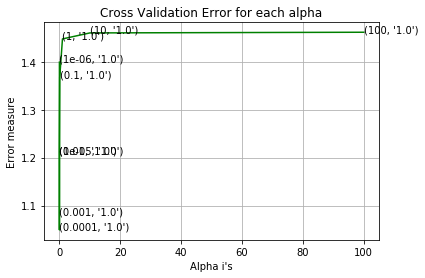

For values of best alpha =  0.0001 The train log loss is: 0.46641980842305025
For values of best alpha =  0.0001 The cross validation log loss is: 1.0491535973994988
For values of best alpha =  0.0001 The test log loss is: 1.0443039608528668


In [61]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_14_55k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_55k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_55k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_55k)
    cv_log_error_array_n_14_55k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_55k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_55k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_55k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_55k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_55k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_55k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_55k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_55k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_55k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.4661518716917028
for alpha = 1e-05
Log Loss : 1.175430693296278
for alpha = 0.0001
Log Loss : 1.1006721923165392
for alpha = 0.001
Log Loss : 1.1187913636287992
for alpha = 0.01
Log Loss : 1.2060666336038168
for alpha = 0.1
Log Loss : 1.3317087783706942
for alpha = 1
Log Loss : 1.3864965498148716
for alpha = 10
Log Loss : 1.3958170693395757
for alpha = 100
Log Loss : 1.3969584449833774


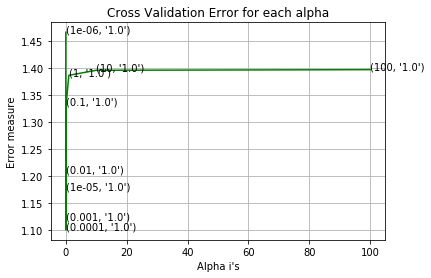

For values of best alpha =  0.0001 The train log loss is: 0.4922793786227071
For values of best alpha =  0.0001 The cross validation log loss is: 1.1006721923165392
For values of best alpha =  0.0001 The test log loss is: 1.0775393827266564


In [64]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_14_4k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_4k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_4k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_4k)
    cv_log_error_array_n_14_4k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_4k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_4k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_4k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_4k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_4k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_4k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_4k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_4k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_4k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.392961555669529
for alpha = 1e-05
Log Loss : 1.1623027784474873
for alpha = 0.0001
Log Loss : 1.0656696999589568
for alpha = 0.001
Log Loss : 1.0966539809170095
for alpha = 0.01
Log Loss : 1.1979973468148342
for alpha = 0.1
Log Loss : 1.3232083646571633
for alpha = 1
Log Loss : 1.3780938905466065
for alpha = 10
Log Loss : 1.3875384867596243
for alpha = 100
Log Loss : 1.3887016056462724


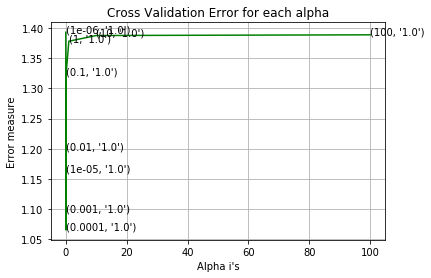

For values of best alpha =  0.0001 The train log loss is: 0.47284031785258357
For values of best alpha =  0.0001 The cross validation log loss is: 1.0656696999589568
For values of best alpha =  0.0001 The test log loss is: 1.0475844861929524


In [70]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_14_45k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_45k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_45k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_45k)
    cv_log_error_array_n_14_45k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_45k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_45k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_45k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_45k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_45k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_45k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_45k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_45k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_45k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.3911202641878968
for alpha = 1e-05
Log Loss : 1.1940939914746296
for alpha = 0.0001
Log Loss : 1.0581084527489086
for alpha = 0.001
Log Loss : 1.095010912987658
for alpha = 0.01
Log Loss : 1.2039125662583714
for alpha = 0.1
Log Loss : 1.336564387714924
for alpha = 1
Log Loss : 1.3938258300662563
for alpha = 10
Log Loss : 1.403319969614093
for alpha = 100
Log Loss : 1.404463527710393


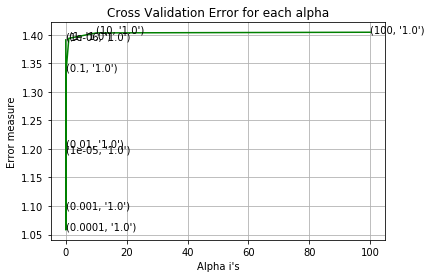

For values of best alpha =  0.0001 The train log loss is: 0.4712420500808941
For values of best alpha =  0.0001 The cross validation log loss is: 1.0581084527489086
For values of best alpha =  0.0001 The test log loss is: 1.0457518506009118


In [73]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array_n_14_48k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_48k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_48k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_48k)
    cv_log_error_array_n_14_48k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_48k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_48k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_48k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_48k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_48k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_48k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_48k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_48k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_48k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-05
Log Loss : 1.560314832323001
for alpha = 0.0001
Log Loss : 1.5339858192930997
for alpha = 0.001
Log Loss : 1.2031189153169322
for alpha = 0.1
Log Loss : 1.2215726010302346


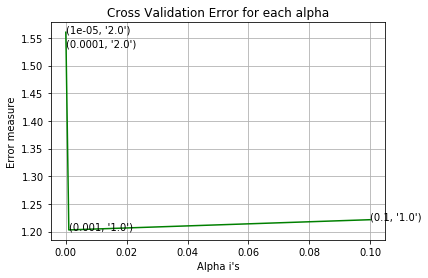

For values of best alpha =  0.001 The train log loss is: 0.903355382078851
For values of best alpha =  0.001 The cross validation log loss is: 1.2031189153169322
For values of best alpha =  0.001 The test log loss is: 1.1837282968761482


In [76]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [0.00001,0.0001,0.001,0.1]
cv_log_error_array_n_14_780k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_780k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_780k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_780k)
    cv_log_error_array_n_14_780k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_780k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_780k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_780k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_780k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_780k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_780k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_780k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_780k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_780k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [23]:
from sklearn.metrics import log_loss

In [24]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
#cv_x_onehotCoding_2_8k
alpha = [10**i for i in range(-6,3) ]
cv_log_error_array_n_14_780k = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_780k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_780k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_780k)
    cv_log_error_array_n_14_780k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y,sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_780k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_780k)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_780k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_780k)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_n_14_780k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_780k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_780k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_780k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_780k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06


NameError: name 'train_x_onehotCoding_n_14_780k' is not defined

<h2>4.4. Linear Support Vector Machines</h2>

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.3433661656188776
for C = 0.0001
Log Loss : 1.189627694032584
for C = 0.001
Log Loss : 1.265949083978304
for C = 0.01
Log Loss : 1.3818617347207025
for C = 0.1
Log Loss : 1.3541394363413846
for C = 1
Log Loss : 1.3956118649643963
for C = 10
Log Loss : 1.3999789590369491
for C = 100
Log Loss : 1.3999789572521715


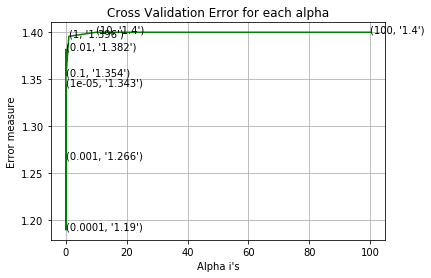

For values of best alpha =  0.0001 The train log loss is: 0.47905099195111683
For values of best alpha =  0.0001 The cross validation log loss is: 1.189627694032584
For values of best alpha =  0.0001 The test log loss is: 1.1877956902909


In [52]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# def ault parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array_n_14_1k = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_n_14_1k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_n_14_1k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_n_14_1k)
    cv_log_error_array_n_14_1k.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array_n_14_1k,c='g')
for i, txt in enumerate(np.round(cv_log_error_array_n_14_1k,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array_n_14_1k[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array_n_14_1k)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_n_14_1k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_n_14_1k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_n_14_1k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_n_14_1k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_n_14_1k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# def ault parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>4.4.2. Testing model with best hyper parameters</h3>

Log loss : 1.1398040719997078
Number of mis-classified points : 0.35714285714285715
-------------------- Confusion matrix --------------------


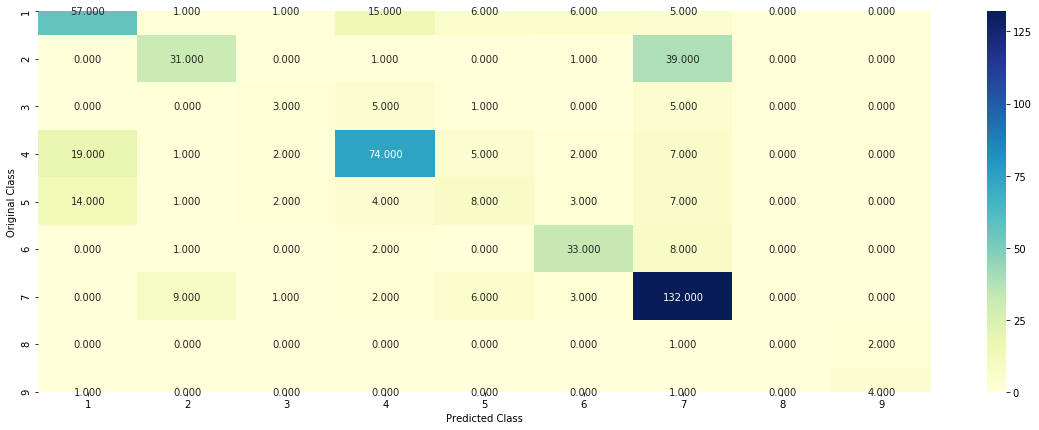

-------------------- Precision matrix (Columm Sum=1) --------------------


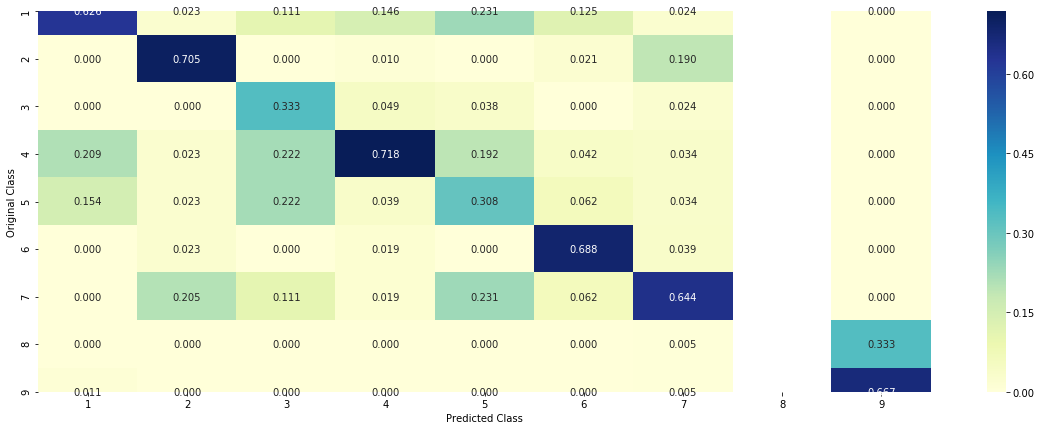

-------------------- Recall matrix (Row sum=1) --------------------


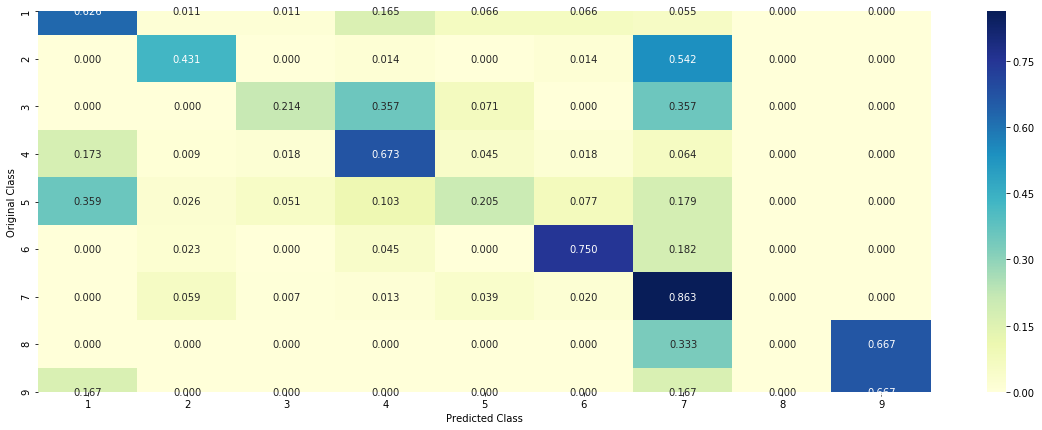

In [131]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>4.3.3. Feature Importance</h3>

<h4>4.3.3.1. For InCorrectly classified point</h4>

In [132]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.035  0.0392 0.6766 0.0295 0.0411 0.0076 0.1627 0.0057 0.0026]]
Actual Class : 7
--------------------------------------------------
198 Text feature [nontargeting] present in test data point [True]
216 Text feature [interpatient] present in test data point [True]
217 Text feature [n520y] present in test data point [True]
218 Text feature [g831] present in test data point [True]
219 Text feature [g831e] present in test data point [True]
220 Text feature [v194m] present in test data point [True]
221 Text feature [choudhary] present in test data point [True]
222 Text feature [rs35602083] present in test data point [True]
223 Text feature [knapper] present in test data point [True]
224 Text feature [homozyogus] present in test data point [True]
225 Text feature [caryboxyl] present in test data point [True]
226 Text feature [n816] present in test data point [True]
227 Text feature [syampurnawati] present in test data point [True]
228 Tex

<h4>4.3.3.2. For correctly classified point</h4>

In [133]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[1.780e-02 1.750e-02 3.100e-03 9.133e-01 1.410e-02 5.300e-03 2.480e-02
  3.800e-03 3.000e-04]]
Actual Class : 4
--------------------------------------------------
120 Text feature [2659] present in test data point [True]
173 Text feature [hartwell] present in test data point [True]
214 Text feature [cosegregated] present in test data point [True]
324 Text feature [germline] present in test data point [True]
326 Text feature [truncate] present in test data point [True]
378 Text feature [material] present in test data point [True]
401 Text feature [carriers] present in test data point [True]
434 Text feature [1292] present in test data point [True]
440 Text feature [suppressor] present in test data point [True]
472 Text feature [apparently] present in test data point [True]
477 Text feature [familial] present in test data point [True]
499 Text feature [deleted] present in test data point [True]
Out of the top  500  features  12 are pres

### Linear SVM with 1k features

for C = 1e-05
Log Loss : 1.1477862372812537
for C = 0.0001
Log Loss : 1.101092655798345
for C = 0.001
Log Loss : 1.1418503568505154
for C = 0.01
Log Loss : 1.3165965152474406
for C = 0.1
Log Loss : 1.5677796238900559
for C = 1
Log Loss : 1.6579715900826821
for C = 10
Log Loss : 1.6579716666333084
for C = 100
Log Loss : 1.6579715968199167


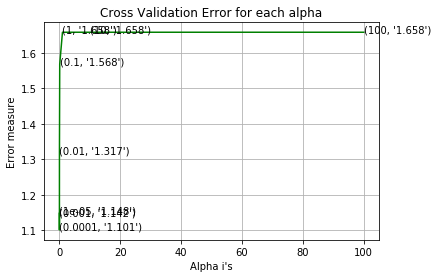

For values of best alpha =  0.0001 The train log loss is: 0.40537749067001067
For values of best alpha =  0.0001 The cross validation log loss is: 1.101092655798345
For values of best alpha =  0.0001 The test log loss is: 1.0753481692188638


In [223]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_1k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_1k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_1k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_1k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_1k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_1k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-05
Log Loss : 1.1414115864359886
for C = 0.0001
Log Loss : 1.1008571506831273
for C = 0.001
Log Loss : 1.1020567561387897
for C = 0.01
Log Loss : 1.3244194696229294
for C = 0.1
Log Loss : 1.7980900433318496
for C = 1
Log Loss : 1.9429466321886801
for C = 10
Log Loss : 1.9429472095790845
for C = 100
Log Loss : 1.942948135682146


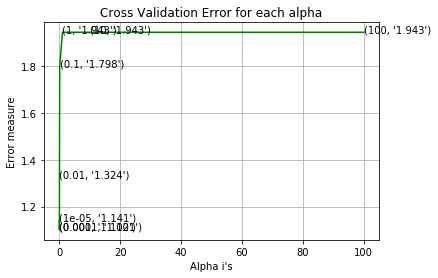

For values of best alpha =  0.0001 The train log loss is: 0.3820556082356948
For values of best alpha =  0.0001 The cross validation log loss is: 1.1008571506831273
For values of best alpha =  0.0001 The test log loss is: 1.0061750837297911


In [231]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_2k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_2k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_2k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_2k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_2k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Linear svm with 5k features

for C = 1e-05
Log Loss : 1.1623700926160279
for C = 0.0001
Log Loss : 1.1013462095018696
for C = 0.001
Log Loss : 1.1076056365449531
for C = 0.01
Log Loss : 1.2104651543801284
for C = 0.1
Log Loss : 1.7632164993646422
for C = 1
Log Loss : 1.8328367269269001
for C = 10
Log Loss : 1.832836995874398
for C = 100
Log Loss : 1.8328370246145755


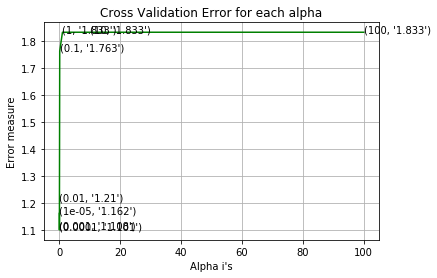

For values of best alpha =  0.0001 The train log loss is: 0.40193242719921796
For values of best alpha =  0.0001 The cross validation log loss is: 1.1013462095018696
For values of best alpha =  0.0001 The test log loss is: 1.0455416801660453


In [240]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated mo

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_5k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_5k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_5k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_5k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_5k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_5k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_5k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_5k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-05
Log Loss : 1.1997505667728492
for C = 0.0001
Log Loss : 1.1356126914428644
for C = 0.001
Log Loss : 1.1063487992180052
for C = 0.01
Log Loss : 1.1816165393435114
for C = 0.1
Log Loss : 1.6377164122707681
for C = 1
Log Loss : 1.755740512798747
for C = 10
Log Loss : 1.7557430809533177
for C = 100
Log Loss : 1.7557429991919717


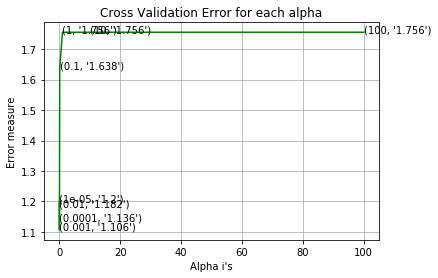

For values of best alpha =  0.001 The train log loss is: 0.46363920113774765
For values of best alpha =  0.001 The cross validation log loss is: 1.1063487992180052
For values of best alpha =  0.001 The test log loss is: 1.0280108754820971


In [241]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated mo

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_10k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_10k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_10k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_10k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_10k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_10k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_10k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_10k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-05
Log Loss : 1.1282761813427644
for C = 0.0001
Log Loss : 1.0958436718424598
for C = 0.001
Log Loss : 1.0989042971744643
for C = 0.01
Log Loss : 1.2919381448787455
for C = 0.1
Log Loss : 1.7954325274865588
for C = 1
Log Loss : 1.929701139154443
for C = 10
Log Loss : 1.9297014713929073
for C = 100
Log Loss : 1.9297015477696275


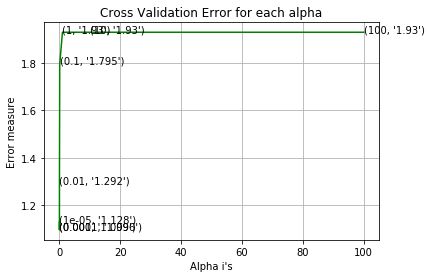

For values of best alpha =  0.0001 The train log loss is: 0.38932292663892043
For values of best alpha =  0.0001 The cross validation log loss is: 1.0958436718424598
For values of best alpha =  0.0001 The test log loss is: 1.0056983864511677


In [249]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated mo

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_2_5k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2_5k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2_5k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_2_5k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2_5k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_2_5k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_2_5k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_2_5k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-05
Log Loss : 1.1373667476751887
for C = 0.0001
Log Loss : 1.0619782367667854
for C = 0.001
Log Loss : 1.0992126751512123
for C = 0.01
Log Loss : 1.2702996173412364
for C = 0.1
Log Loss : 1.7880303969660531
for C = 1
Log Loss : 1.9149189883614723
for C = 10
Log Loss : 1.9149190747854672
for C = 100
Log Loss : 1.9149190984263924


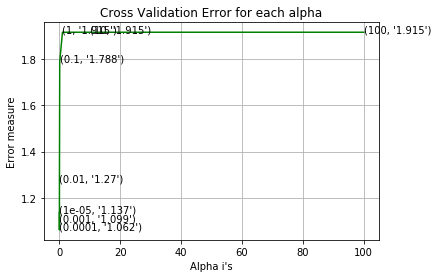

For values of best alpha =  0.0001 The train log loss is: 0.3794259127869804
For values of best alpha =  0.0001 The cross validation log loss is: 1.0619782367667854
For values of best alpha =  0.0001 The test log loss is: 1.0013336498053675


In [251]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated mo

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_2_8k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2_8k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2_8k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_2_8k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2_8k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [256]:
best_alpha=1

Log loss : 1.0695180468837053
Number of mis-classified points : 0.3458646616541353
-------------------- Confusion matrix --------------------


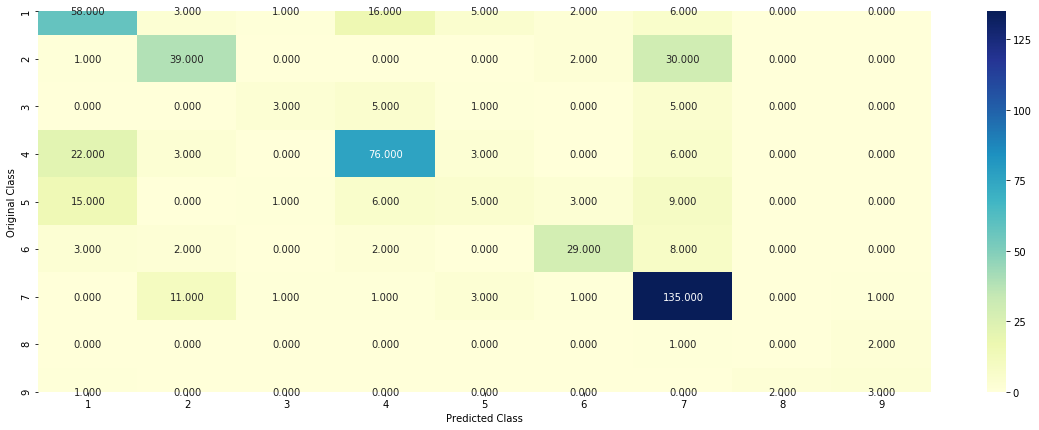

-------------------- Precision matrix (Columm Sum=1) --------------------


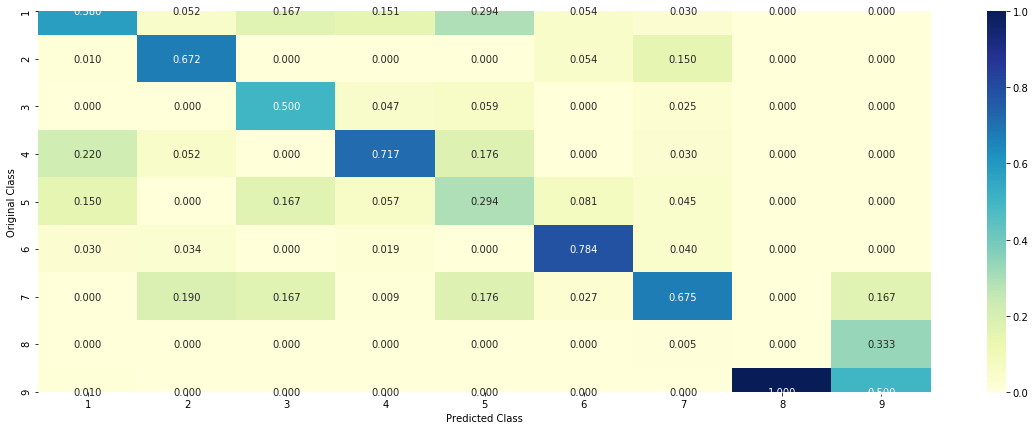

-------------------- Recall matrix (Row sum=1) --------------------


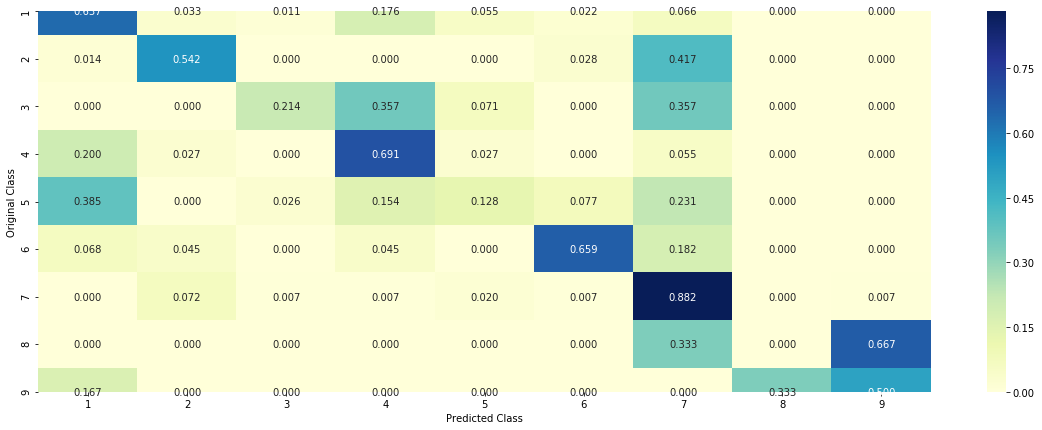

In [257]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding_2_8k, train_y,cv_x_onehotCoding_2_8k,cv_y, clf)

for C = 5e-05
Log Loss : 1.096739715383846
for C = 8e-05
Log Loss : 1.0776746446974461
for C = 0.0002
Log Loss : 1.0607850351015702
for C = 0.0005
Log Loss : 1.0761051172674678


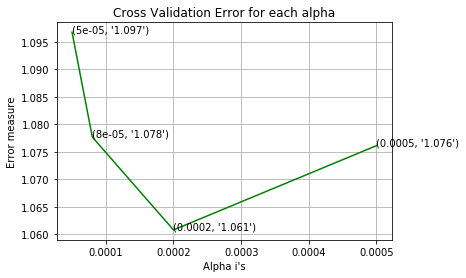

For values of best alpha =  0.0002 The train log loss is: 0.3683594256137041
For values of best alpha =  0.0002 The cross validation log loss is: 1.0607850351015702
For values of best alpha =  0.0002 The test log loss is: 0.9984513655455016


In [252]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated mo

alpha = [0.00005,0.00008,0.0002,0.0005]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_2_8k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2_8k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2_8k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_2_8k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2_8k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 0.0002
Log Loss : 1.0607850351015702
for C = 0.00025
Log Loss : 1.0695180468837053
for C = 0.0003
Log Loss : 1.0679796384128024
for C = 0.0004
Log Loss : 1.0710735645274192


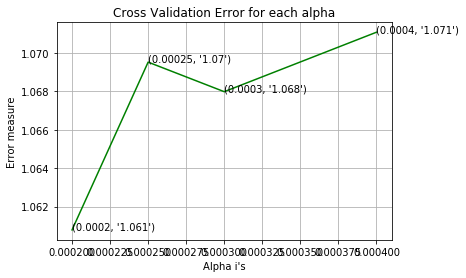

For values of best alpha =  0.0002 The train log loss is: 0.3683594256137041
For values of best alpha =  0.0002 The cross validation log loss is: 1.0607850351015702
For values of best alpha =  0.0002 The test log loss is: 0.9984513655455016


In [253]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated mo

alpha = [0.0002,0.00025,0.0003,0.0004]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_2_8k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2_8k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2_8k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_2_8k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2_8k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 0.0002
Log Loss : 1.1479696118753713
for C = 0.00025
Log Loss : 1.1084100674974633
for C = 0.0003
Log Loss : 1.107675880558621
for C = 0.0004
Log Loss : 1.123518240563308


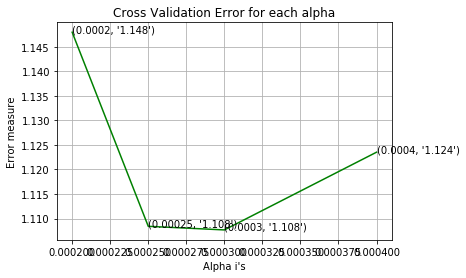

For values of best alpha =  0.0003 The train log loss is: 0.3603837446291373
For values of best alpha =  0.0003 The cross validation log loss is: 1.107675880558621
For values of best alpha =  0.0003 The test log loss is: 1.0049099854434187


In [32]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated mo

alpha = [0.0002,0.00025,0.0003,0.0004]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_2_8k, train_y_3_8k)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_2_8k, train_y_3_8k)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_2_8k)
    cv_log_error_array.append(log_loss(cv_y_3_8k, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y_3_8k, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_2_8k, train_y_3_8k)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_2_8k, train_y_3_8k)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_2_8k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Summary:
###         1.Task 5 in assignment is comleted as the log loss is less than 1
###         2.Here,I used linear SVM where alpha 0.0002
###         3.Tfidf featirization is used with 2800 features

for C = 1e-05
Log Loss : 1.119750099428964
for C = 0.0001
Log Loss : 1.0771817301563569
for C = 0.001
Log Loss : 1.0987237741739861
for C = 0.01
Log Loss : 1.2714943140819166
for C = 0.1
Log Loss : 1.7875719106264163
for C = 1
Log Loss : 1.9094559751167635
for C = 10
Log Loss : 1.9094559828902524
for C = 100
Log Loss : 1.909456025643729


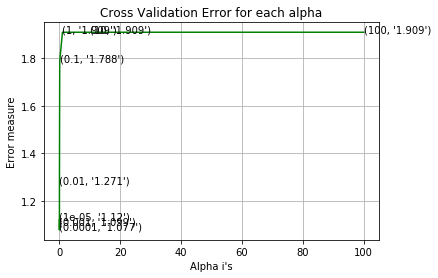

For values of best alpha =  0.0001 The train log loss is: 0.39260745181119033
For values of best alpha =  0.0001 The cross validation log loss is: 1.0771817301563569
For values of best alpha =  0.0001 The test log loss is: 1.0174336733428477


In [245]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated mo

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding_3k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_3k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_3k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding_3k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_3k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_3k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_3k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_3k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h2>4.5 Random Forest Classifier</h2>

<h3>4.5.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [134]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2291365270848487
for n_estimators = 100 and max depth =  10
Log Loss : 1.1786683434522949
for n_estimators = 200 and max depth =  5
Log Loss : 1.2115577001485247
for n_estimators = 200 and max depth =  10
Log Loss : 1.1685662419857135
for n_estimators = 500 and max depth =  5
Log Loss : 1.2100792639432887
for n_estimators = 500 and max depth =  10
Log Loss : 1.16309429426819
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2112070968828086
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1613587712364672
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2078770847236209
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1602822455374144
For values of best estimator =  2000 The train log loss is: 0.6511804601038388
For values of best estimator =  2000 The cross validation log loss is: 1.1602822455374147
For values of best estimator =  2000 The test log loss is: 1.143216284454515


<h3>4.5.2. Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.1602822455374144
Number of mis-classified points : 0.37406015037593987
-------------------- Confusion matrix --------------------


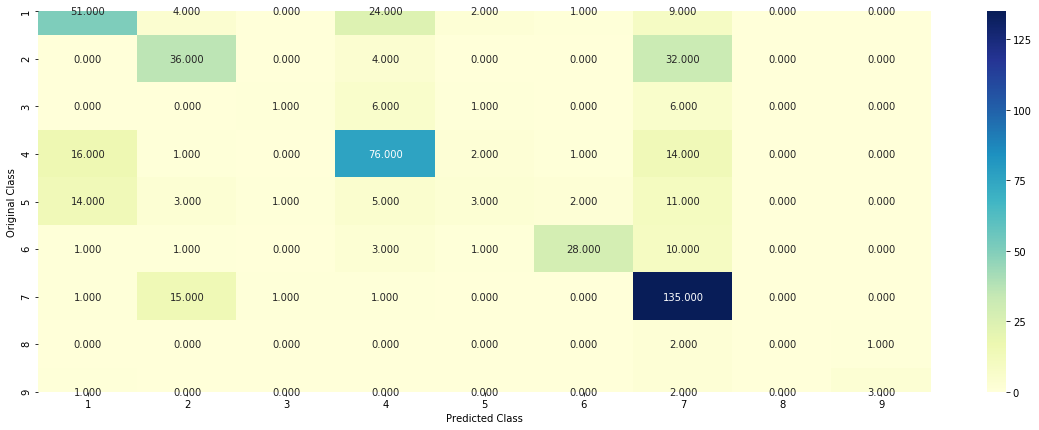

-------------------- Precision matrix (Columm Sum=1) --------------------


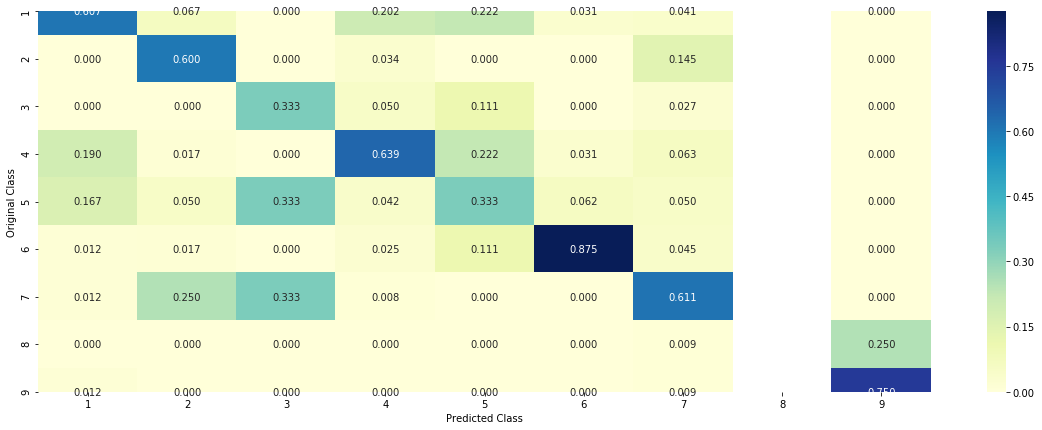

-------------------- Recall matrix (Row sum=1) --------------------


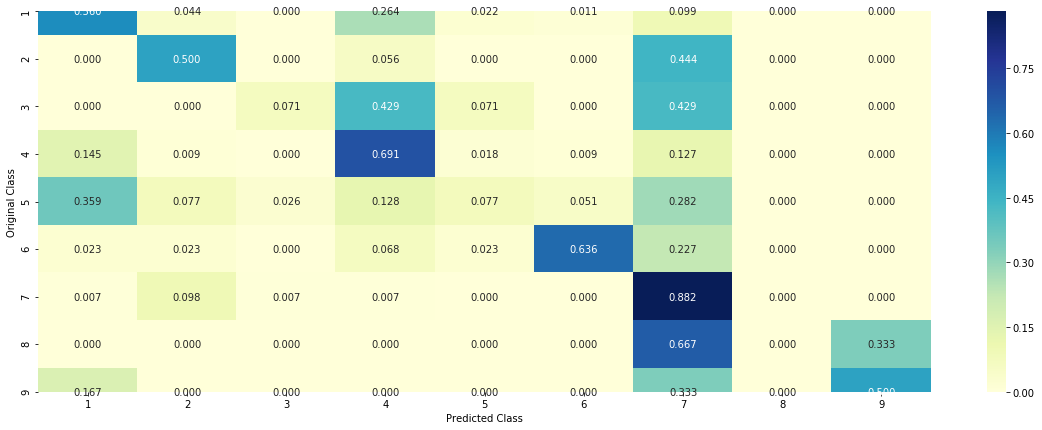

In [135]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>4.5.3. Feature Importance</h3>

<h4>4.5.3.1. Correctly InClassified point</h4>

In [136]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.0397 0.0915 0.3729 0.0297 0.0475 0.0373 0.3717 0.0053 0.0043]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [inhibitor] present in test data point [True]
5 Text feature [inhibitors] present in test data point [True]
6 Text feature [phosphorylation] present in test data point [True]
7 Text feature [constitutive] present in test data point [True]
8 Text feature [treatment] present in test data point [True]
9 Text feature [activated] present in test data point [True]
10 Text feature [oncogenic] present in test data point [True]
12 Text feature [signaling] present in test data point [True]
13 Text feature [treated] present in test data point [True]
14 Text feat

<h4>4.5.3.2. Correctly Classified point</h4>

In [137]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1392 0.0379 0.0178 0.6656 0.0507 0.0427 0.0371 0.0045 0.0045]]
Actuall Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [inhibitor] present in test data point [True]
5 Text feature [inhibitors] present in test data point [True]
6 Text feature [phosphorylation] present in test data point [True]
10 Text feature [oncogenic] present in test data point [True]
11 Text feature [suppressor] present in test data point [True]
12 Text feature [signaling] present in test data point [True]
15 Text feature [loss] present in test data point [True]
19 Text feature [nonsense] present in test data point [True]
21 Text feature [proliferation] present in test data point [True]
22 Text feature [downstream] present in test data point [True]
23 Text feature [therapy] present in test data point [True]
24 Text f

<h2>4.5 Random Forest Classifier_1k</h2>

In [184]:
alpha_1k = [100,200,500,1000,2000]
max_depth_1k = [5, 10]
cv_log_error_array_1k = []
for i in alpha_1k:
    for j in max_depth_1k:
        print("for n_estimators =", i,"and max depth_1k = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding_1k, train_y_1k)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding_1k, train_y_1k)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_1k)
        cv_log_error_array_1k.append(log_loss(cv_y_1k, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y_1k, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha_1k = np.argmin(cv_log_error_array_1k)
clf = RandomForestClassifier(n_estimators=alpha_1k[int(best_alpha_1k/2)], criterion='gini', max_depth=max_depth_1k[int(best_alpha_1k%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding_1k, train_y_1k)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_1k, train_y_1k)

predict_y_1k = sig_clf.predict_proba(train_x_onehotCoding_1k)
print('For values of best estimator = ', alpha_1k[int(best_alpha_1k/2)], "The train log loss is:",log_loss(y_train, predict_y_1k, labels=clf.classes_, eps=1e-15))
predict_y_1k = sig_clf.predict_proba(cv_x_onehotCoding_1k)
print('For values of best estimator = ', alpha_1k[int(best_alpha_1k/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y_1k, labels=clf.classes_, eps=1e-15))
predict_y_1k = sig_clf.predict_proba(test_x_onehotCoding_1k)
print('For values of best estimator = ', alpha_1k[int(best_alpha_1k/2)], "The test log loss is:",log_loss(y_test, predict_y_1k, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth_1k =  5
Log Loss : 1.2735978659633305
for n_estimators = 100 and max depth_1k =  10
Log Loss : 1.3266740778427968
for n_estimators = 200 and max depth_1k =  5
Log Loss : 1.2662236980314117
for n_estimators = 200 and max depth_1k =  10
Log Loss : 1.3127142829181986
for n_estimators = 500 and max depth_1k =  5
Log Loss : 1.2567943374739827
for n_estimators = 500 and max depth_1k =  10
Log Loss : 1.3073911929880437
for n_estimators = 1000 and max depth_1k =  5
Log Loss : 1.2467494946567432
for n_estimators = 1000 and max depth_1k =  10
Log Loss : 1.3058054521345708
for n_estimators = 2000 and max depth_1k =  5
Log Loss : 1.2450649150021258
for n_estimators = 2000 and max depth_1k =  10
Log Loss : 1.3086754598268007
For values of best estimator =  2000 The train log loss is: 0.8510924233342114
For values of best estimator =  2000 The cross validation log loss is: 1.2450649150021258
For values of best estimator =  2000 The test log loss is: 1.24263727144

Log loss : 1.2450649150021258
Number of mis-classified points : 0.4323308270676692
-------------------- Confusion matrix --------------------


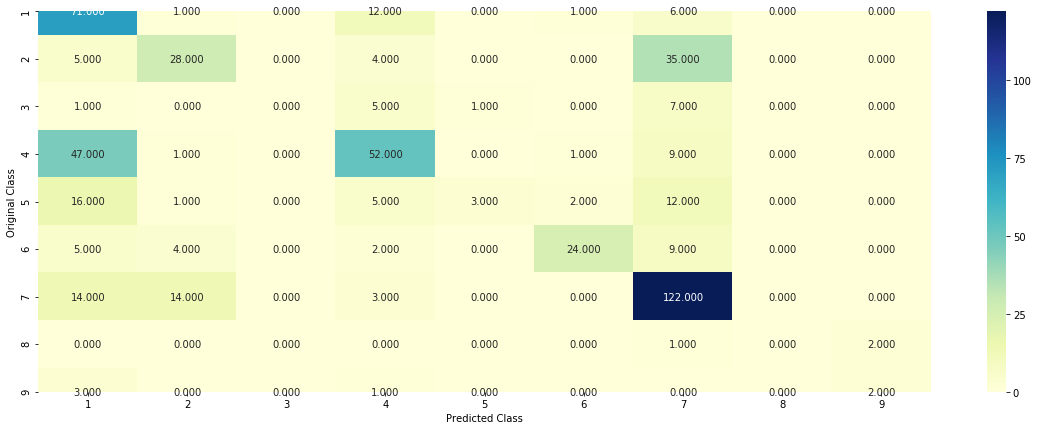

-------------------- Precision matrix (Columm Sum=1) --------------------


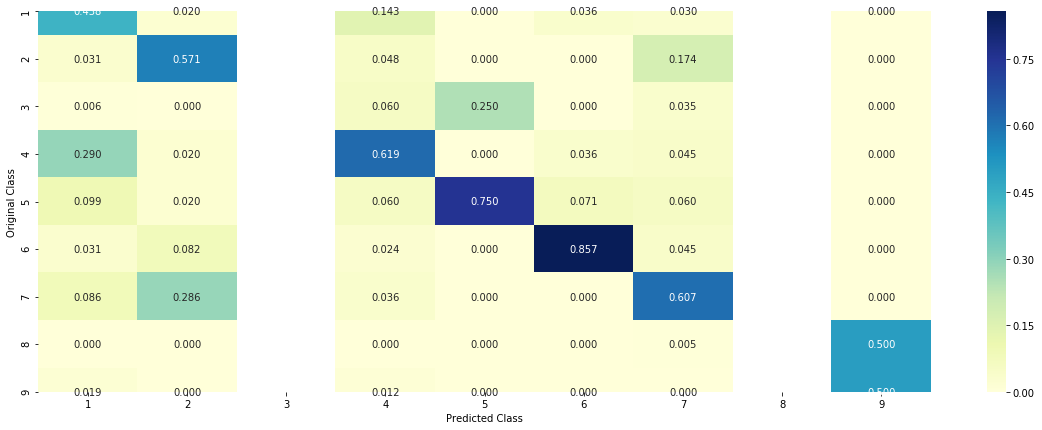

-------------------- Recall matrix (Row sum=1) --------------------


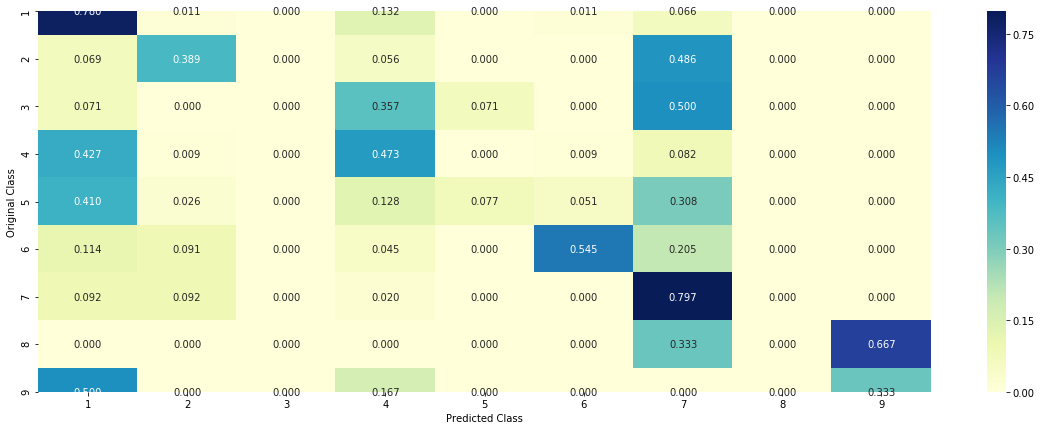

In [185]:
clf = RandomForestClassifier(n_estimators=alpha_1k[int(best_alpha_1k/2)], criterion='gini', max_depth=max_depth_1k[int(best_alpha_1k%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding_1k, train_y_1k,cv_x_onehotCoding_1k,cv_y_1k, clf)

<h3>4.5.3. Hyper paramter tuning (With Response Coding)</h3>

In [139]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.3046034932595862
for n_estimators = 10 and max depth =  3
Log Loss : 1.943038973789212
for n_estimators = 10 and max depth =  5
Log Loss : 1.5058118753541088
for n_estimators = 10 and max depth =  10
Log Loss : 1.717132503100421
for n_estimators = 50 and max depth =  2
Log Loss : 1.930348252298727
for n_estimators = 50 and max depth =  3
Log Loss : 1.6177068624022468
for n_estimators = 50 and max depth =  5
Log Loss : 1.5016188516681752
for n_estimators = 50 and max depth =  10
Log Loss : 1.670313873734734
for n_estimators = 100 and max depth =  2
Log Loss : 1.7502208934870593
for n_estimators = 100 and max depth =  3
Log Loss : 1.622984645443502
for n_estimators = 100 and max depth =  5
Log Loss : 1.3811502862839748
for n_estimators = 100 and max depth =  10
Log Loss : 1.687538359620617
for n_estimators = 200 and max depth =  2
Log Loss : 1.8313714974988318
for n_estimators = 200 and max depth =  3
Log Loss : 1.6769638299728828
for

<h3>4.5.4. Testing model with best hyper parameters (Response Coding)</h3>

Log loss : 1.3811502862839762
Number of mis-classified points : 0.48872180451127817
-------------------- Confusion matrix --------------------


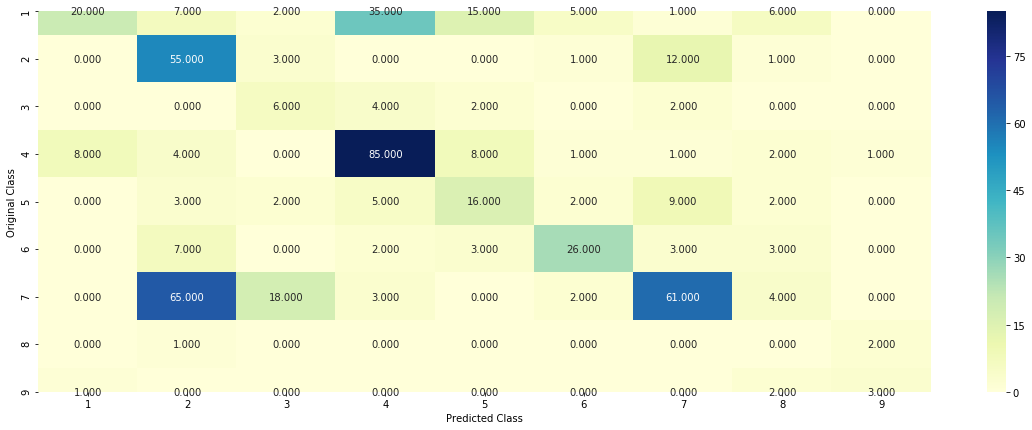

-------------------- Precision matrix (Columm Sum=1) --------------------


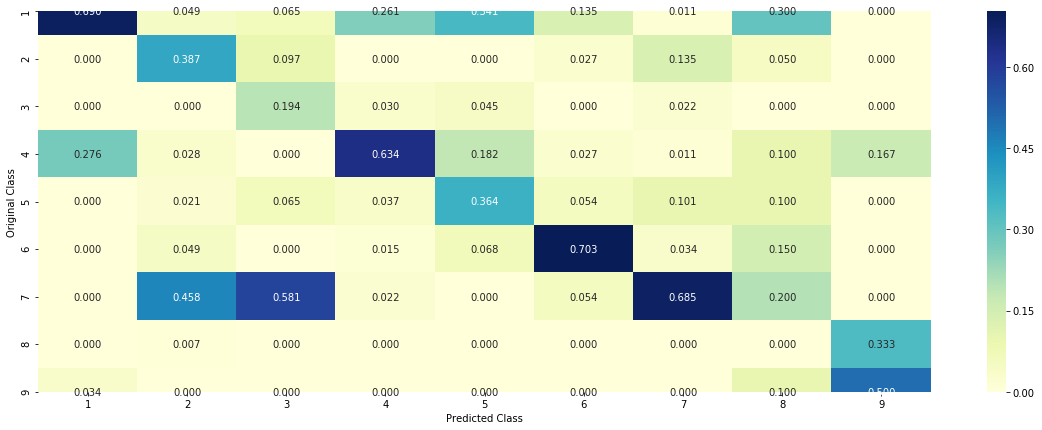

-------------------- Recall matrix (Row sum=1) --------------------


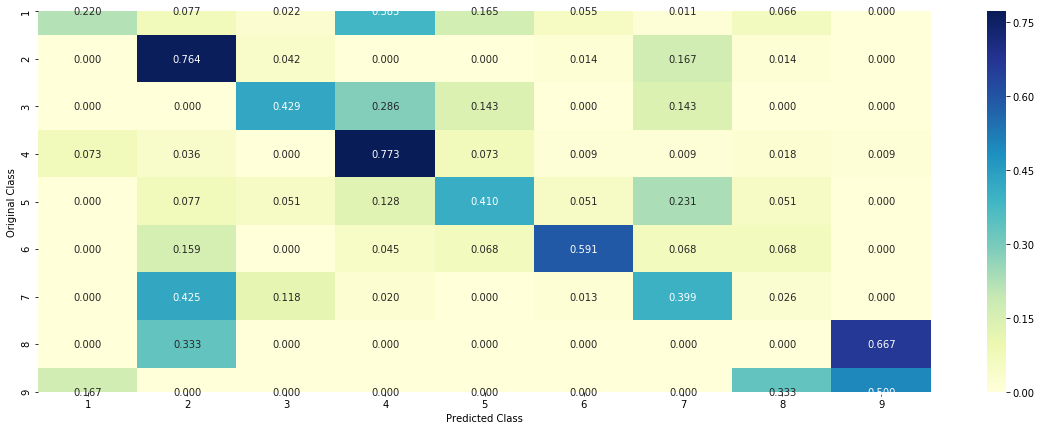

In [140]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

<h3>4.5.5. Feature Importance</h3>

<h4>4.5.5.1. InCorrectly Classified point</h4>

In [141]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 3
Predicted Class Probabilities: [[0.006  0.0354 0.7932 0.0072 0.0088 0.0113 0.1215 0.0097 0.0068]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature


<h4>4.5.5.2. correctly Classified point</h4>

In [142]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.0551 0.0362 0.1399 0.6164 0.022  0.0419 0.0094 0.0384 0.0408]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature


<h2>4.7 Stack the models </h2>

<h3>4.7.1 testing with hyper parameter tuning</h3>

In [0]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.24
Support vector machines : Log Loss: 1.72
Naive Bayes : Log Loss: 1.37
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.179
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.049
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.577
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.224
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.366
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.690


In [143]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.15
Support vector machines : Log Loss: 1.53
Naive Bayes : Log Loss: 1.29
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.177
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.031
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.504
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.166
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.313
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.622


<h3>4.7.2 testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.6760284396805781
Log loss (CV) on the stacking classifier : 1.2243084610674686
Log loss (test) on the stacking classifier : 1.1562525475350196
Number of missclassified point : 0.37293233082706767
-------------------- Confusion matrix --------------------


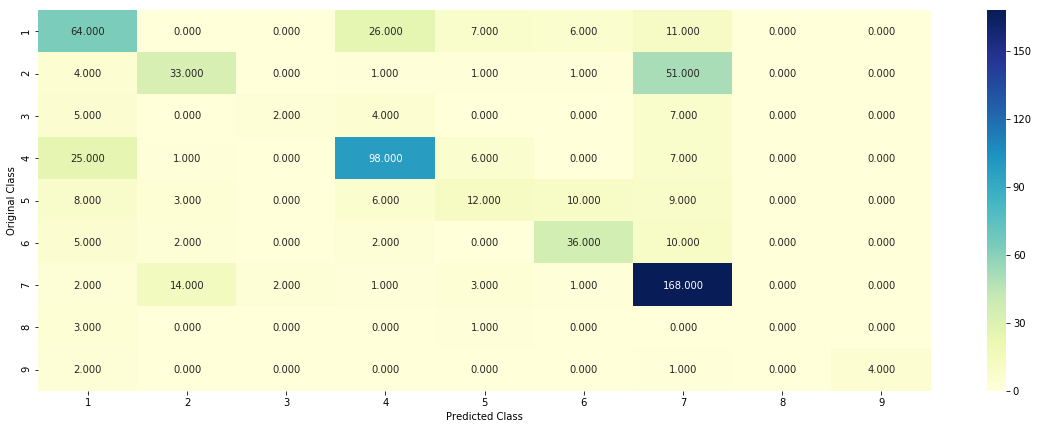

-------------------- Precision matrix (Columm Sum=1) --------------------


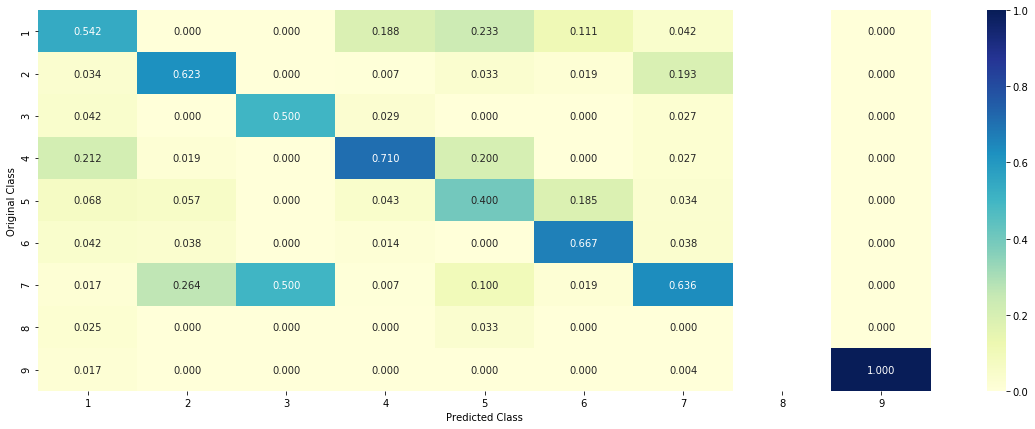

-------------------- Recall matrix (Row sum=1) --------------------


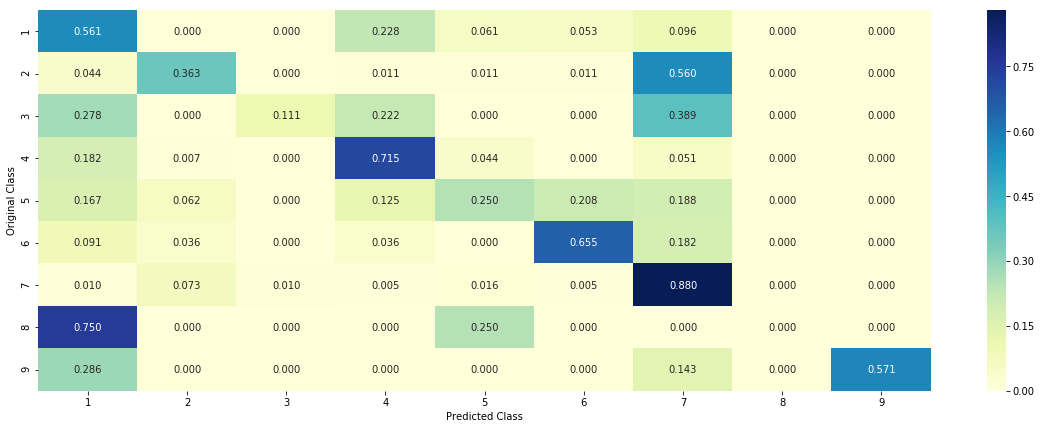

In [0]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

Log loss (train) on the stacking classifier : 0.6166959526223077
Log loss (CV) on the stacking classifier : 1.1659804954585689
Log loss (test) on the stacking classifier : 1.1175451272779178
Number of missclassified point : 0.3473684210526316
-------------------- Confusion matrix --------------------


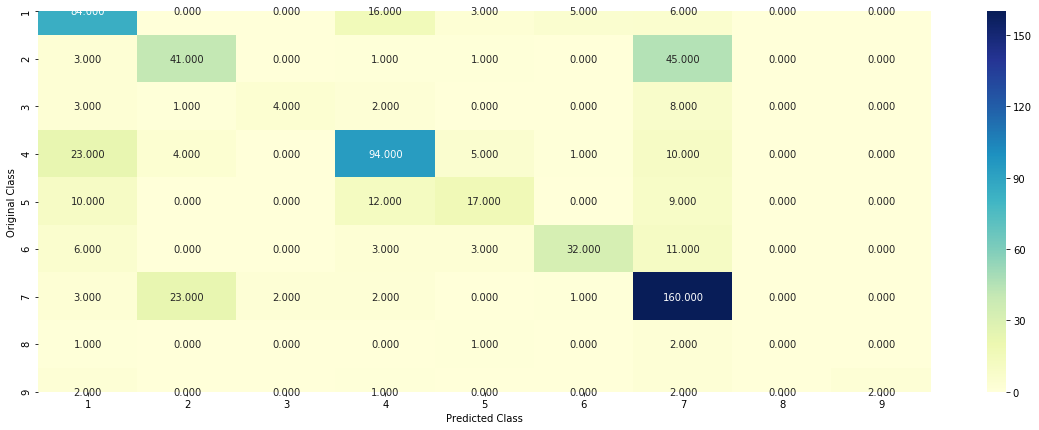

-------------------- Precision matrix (Columm Sum=1) --------------------


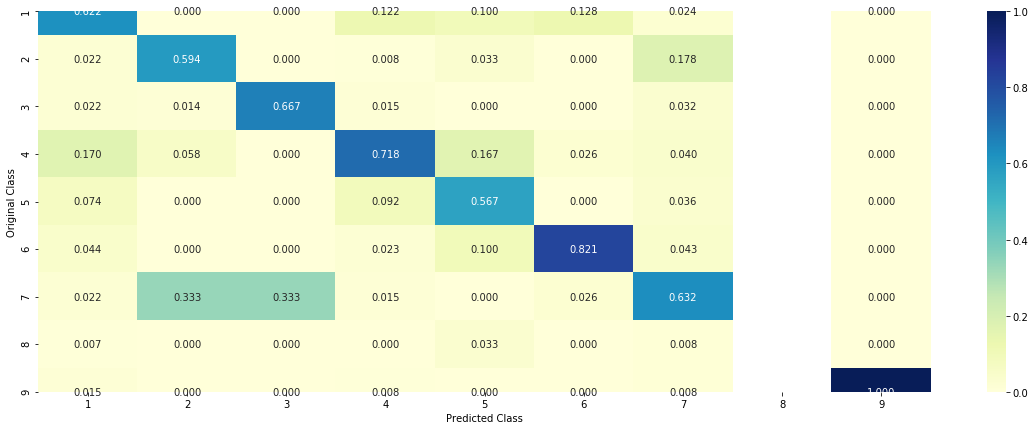

-------------------- Recall matrix (Row sum=1) --------------------


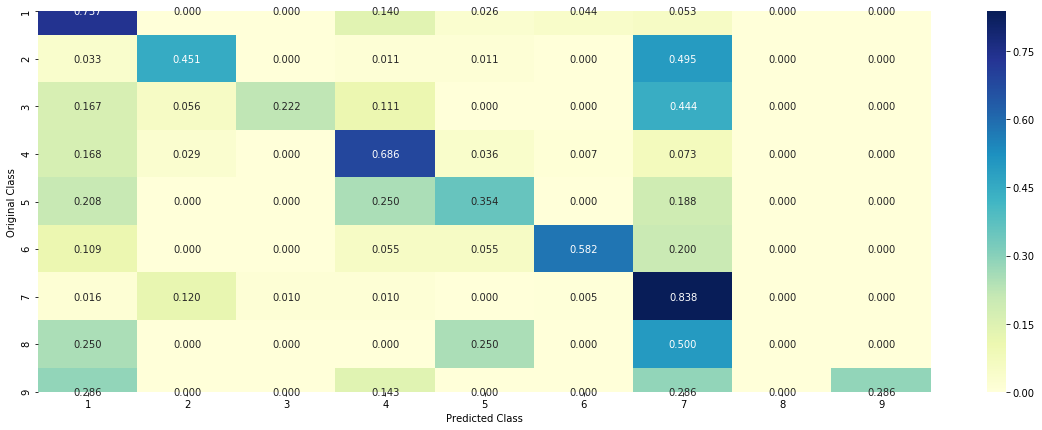

In [144]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h3>4.7.3 Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.8323266551323523
Log loss (CV) on the VotingClassifier : 1.1849282476096827
Log loss (test) on the VotingClassifier : 1.1252455272447013
Number of missclassified point : 0.3458646616541353
-------------------- Confusion matrix --------------------


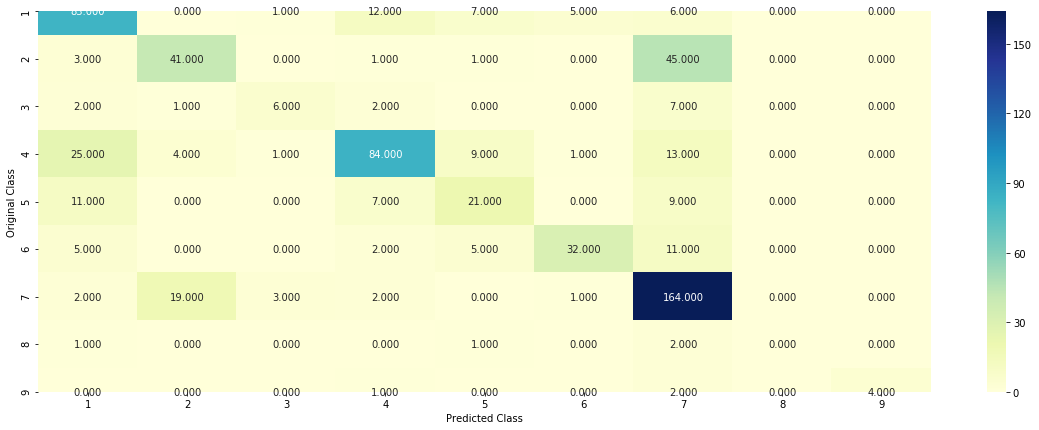

-------------------- Precision matrix (Columm Sum=1) --------------------


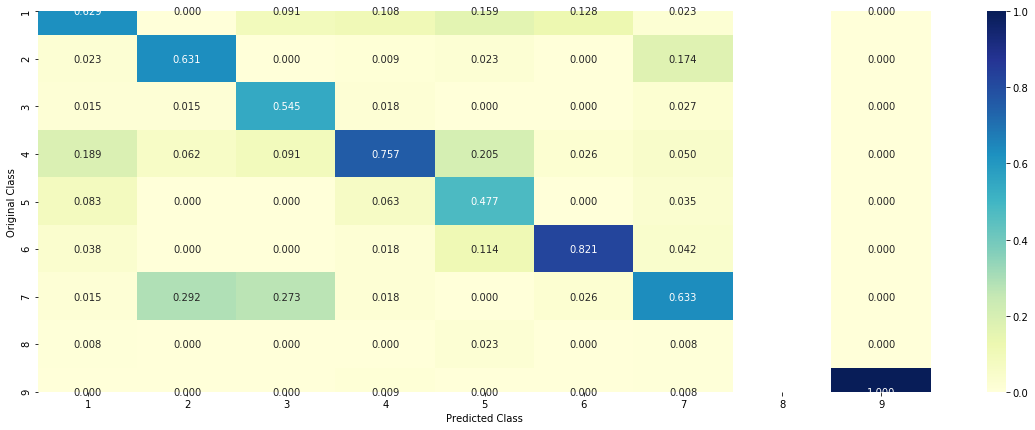

-------------------- Recall matrix (Row sum=1) --------------------


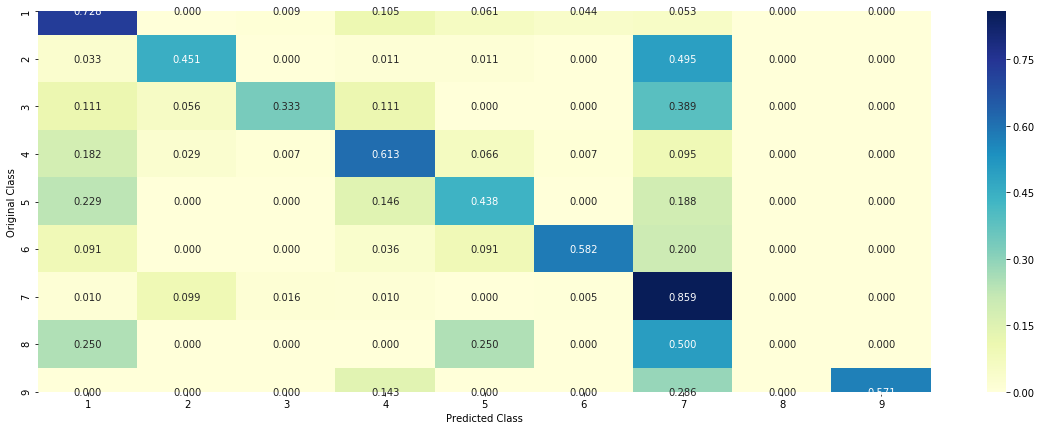

In [145]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

<h1>4.Logistic regression with CountVectorizer Features, with both unigrams and bigrams</h1>

In [187]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer_bi = CountVectorizer(ngram_range=(1,2))
train_text_feature_onehotCoding_bi = text_vectorizer_bi.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features_bi= text_vectorizer_bi.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts_bi = train_text_feature_onehotCoding_bi.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict_bi = dict(zip(list(train_text_features_bi),train_text_fea_counts_bi))


print("Total number of unique words in train data :", len(train_text_features_bi))

Total number of unique words in train data : 2339502


In [188]:
dict_list_bi = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text_bi = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list_bi.append(extract_dictionary_paddle(cls_text_bi))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict_bi = extract_dictionary_paddle(train_df)


confuse_array_bi = []
for i in train_text_features_bi:
    ratios_bi = []
    max_val_bi = -1
    for j in range(0,9):
        ratios_bi.append((dict_list_bi[j][i]+10 )/(total_dict_bi[i]+90))
    confuse_array_bi.append(ratios_bi)
confuse_array_bi = np.array(confuse_array_bi)

In [189]:
train_text_feature_onehotCoding_bi = normalize(train_text_feature_onehotCoding_bi, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_bi = text_vectorizer_bi.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_bi = normalize(test_text_feature_onehotCoding_bi, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_bi = text_vectorizer_bi.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_bi = normalize(cv_text_feature_onehotCoding_bi, axis=0)

In [190]:
sorted_text_fea_dict_bi = dict(sorted(text_fea_dict_bi.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur_bi = np.array(list(sorted_text_fea_dict_bi.values()))

In [193]:
train_gene_var_onehotCoding_bi = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding_bi = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding_bi = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_bi = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_bi)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding_bi = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_bi)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding_bi = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_bi)).tocsr()
cv_y = np.array(list(cv_df['Class']))

for alpha = 1e-06
Log Loss : 1.5963414384781627
for alpha = 1e-05
Log Loss : 1.5949717250874016
for alpha = 0.0001
Log Loss : 1.5469967002033325
for alpha = 0.001
Log Loss : 1.301658761980127
for alpha = 0.01
Log Loss : 1.2594934282178403
for alpha = 0.1
Log Loss : 1.3075069599528861
for alpha = 1
Log Loss : 1.3405077813872
for alpha = 10
Log Loss : 1.3849037134668156
for alpha = 100
Log Loss : 1.402918524748583


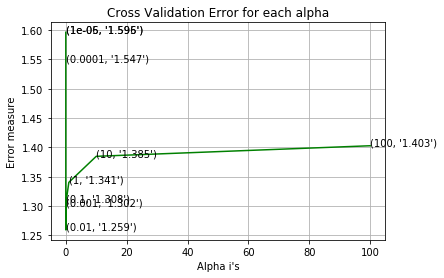

For values of best alpha =  0.01 The train log loss is: 0.5989050364057749
For values of best alpha =  0.01 The cross validation log loss is: 1.2594934282178403
For values of best alpha =  0.01 The test log loss is: 1.229316588603559


In [196]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_bi,train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_bi, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_bi)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_bi, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_bi, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_bi)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_bi)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_bi)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>logistic regression<h/3>

In [200]:
train_x_onehotCoding_bi_wo_var = hstack((train_gene_feature_onehotCoding,train_text_feature_onehotCoding_bi)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding_bi_wo_var = hstack((test_gene_feature_onehotCoding,test_text_feature_onehotCoding_bi)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding_bi_wo_var = hstack((cv_gene_feature_onehotCoding,cv_text_feature_onehotCoding_bi)).tocsr()
cv_y = np.array(list(cv_df['Class']))

for alpha = 1e-06
Log Loss : 1.5932462356530162
for alpha = 1e-05
Log Loss : 1.6088620883938756
for alpha = 0.0001
Log Loss : 1.5280471888731673
for alpha = 0.001
Log Loss : 1.2966301358915762
for alpha = 0.01
Log Loss : 1.2598060579694126
for alpha = 0.1
Log Loss : 1.3087797893246884
for alpha = 1
Log Loss : 1.342133422176903
for alpha = 10
Log Loss : 1.3865261811524239
for alpha = 100
Log Loss : 1.4043670708227252


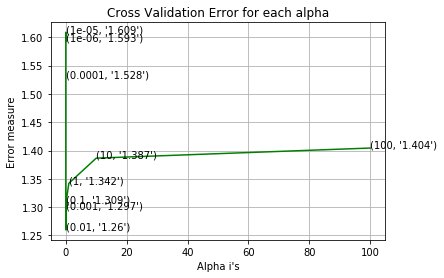

For values of best alpha =  0.01 The train log loss is: 0.6057327461344675
For values of best alpha =  0.01 The cross validation log loss is: 1.2598060579694126
For values of best alpha =  0.01 The test log loss is: 1.2299912424335855


In [201]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_bi_wo_var,train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_bi_wo_var, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_bi_wo_var)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_bi_wo_var, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_bi_wo_var, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_bi_wo_var)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_bi_wo_var)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_bi_wo_var)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Summary:Here,we can observe even if we remove variation feature the minimum best error is not decresing.

#### LR COUNT ALL TEXT

In [42]:
text_vectorizer_count_11 = CountVectorizer()
train_text_feature_onehotCoding_count_11 = text_vectorizer_count_11.fit_transform(train_df['TEXT'])
train_text_feature_onehotCoding_count_11 = normalize(train_text_feature_onehotCoding_count_11, axis=0)
# wetest_text_feature_onehotCoding_2_8k = text_vectorizer_2_8k.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_count_11 = text_vectorizer_count_11.transform(test_df['TEXT'])

test_text_feature_onehotCoding_count_11 = normalize(test_text_feature_onehotCoding_count_11, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_count_11 = text_vectorizer_count_11.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_count_11 = normalize(cv_text_feature_onehotCoding_count_11, axis=0)

train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_count_11 = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_count_11)).tocsr()

test_x_onehotCoding_count_11 = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_count_11)).tocsr()

cv_x_onehotCoding_count_11 = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_count_11)).tocsr()


for alpha = 1e-06
Log Loss : 1.3802823283946979
for alpha = 1e-05
Log Loss : 1.3383178277192167
for alpha = 0.0001
Log Loss : 1.1069446718219664
for alpha = 0.001
Log Loss : 1.0640073041024076
for alpha = 0.01
Log Loss : 1.1242393711758696
for alpha = 0.1
Log Loss : 1.4133020730266792
for alpha = 1
Log Loss : 1.6444242252121268
for alpha = 10
Log Loss : 1.6756879751604452
for alpha = 100
Log Loss : 1.6788970560780327


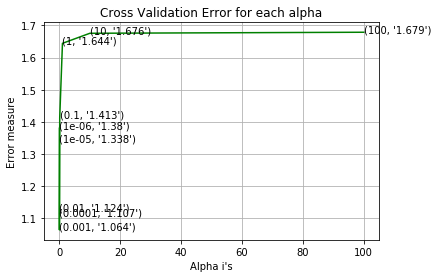

For values of best alpha =  0.001 The train log loss is: 0.5747641623364973
For values of best alpha =  0.001 The cross validation log loss is: 1.0640073041024076
For values of best alpha =  0.001 The test log loss is: 1.0182231916206264


In [43]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_count_11, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_count_11, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_count_11)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_count_11, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_count_11, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_count_11)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_count_11)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_count_11)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### LR_COUNT_TEXT_1K

In [46]:
from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=1000).fit(train_text_feature_onehotCoding_count_11,train_y)
train_text_feature_onehotCoding_count_11_1k_new=selectkbest1.transform(train_text_feature_onehotCoding_count_11)
test_text_feature_onehotCoding_count_11_1k_new=selectkbest1.transform(test_text_feature_onehotCoding_count_11)
cv_text_feature_onehotCoding_count_11_1k_new=selectkbest1.transform(cv_text_feature_onehotCoding_count_11)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_count_11_1k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_count_11_1k_new)).tocsr()

test_x_onehotCoding_count_11_1k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_count_11_1k_new)).tocsr()

cv_x_onehotCoding_count_11_1k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_count_11_1k_new)).tocsr()



for alpha = 1e-06
Log Loss : 1.4022870929830231
for alpha = 1e-05
Log Loss : 1.1672854033940745
for alpha = 0.0001
Log Loss : 1.1032885704275726
for alpha = 0.001
Log Loss : 1.1533198725217104
for alpha = 0.01
Log Loss : 1.2720739889939405
for alpha = 0.1
Log Loss : 1.3900797536387945
for alpha = 1
Log Loss : 1.4241009783374607
for alpha = 10
Log Loss : 1.4299916940346569
for alpha = 100
Log Loss : 1.4307559733528075


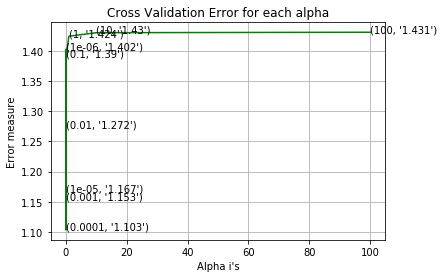

For values of best alpha =  0.0001 The train log loss is: 0.5313709237208087
For values of best alpha =  0.0001 The cross validation log loss is: 1.1032885704275726
For values of best alpha =  0.0001 The test log loss is: 1.111669847733583


In [47]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_count_11_1k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_count_11_1k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_count_11_1k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_count_11_1k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_count_11_1k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_count_11_1k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_count_11_1k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_count_11_1k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### LR_COUNT_TEXT_2K

In [48]:
from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=2000).fit(train_text_feature_onehotCoding_count_11,train_y)
train_text_feature_onehotCoding_count_11_2k_new=selectkbest1.transform(train_text_feature_onehotCoding_count_11)
test_text_feature_onehotCoding_count_11_2k_new=selectkbest1.transform(test_text_feature_onehotCoding_count_11)
cv_text_feature_onehotCoding_count_11_2k_new=selectkbest1.transform(cv_text_feature_onehotCoding_count_11)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_count_11_2k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_count_11_2k_new)).tocsr()

test_x_onehotCoding_count_11_2k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_count_11_2k_new)).tocsr()

cv_x_onehotCoding_count_11_2k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_count_11_2k_new)).tocsr()


for alpha = 1e-06
Log Loss : 1.4026564017674248
for alpha = 1e-05
Log Loss : 1.1649358356873194
for alpha = 0.0001
Log Loss : 1.1024063604011207
for alpha = 0.001
Log Loss : 1.1482435283658832
for alpha = 0.01
Log Loss : 1.2683812703458595
for alpha = 0.1
Log Loss : 1.385466495733273
for alpha = 1
Log Loss : 1.4205921048714496
for alpha = 10
Log Loss : 1.4273421094557925
for alpha = 100
Log Loss : 1.4282093114830634


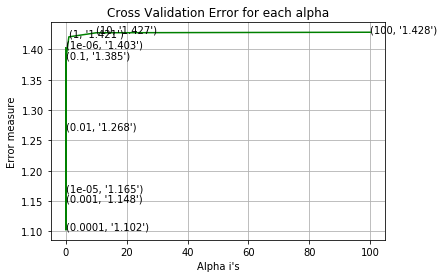

For values of best alpha =  0.0001 The train log loss is: 0.5356161222359921
For values of best alpha =  0.0001 The cross validation log loss is: 1.1024063604011207
For values of best alpha =  0.0001 The test log loss is: 1.1003471208140276


In [49]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_count_11_2k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_count_11_2k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_count_11_2k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_count_11_2k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_count_11_2k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_count_11_2k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_count_11_2k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_count_11_2k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### LR_COUNT_TEXT_5K

In [51]:
from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=5000).fit(train_text_feature_onehotCoding_count_11,train_y)
train_text_feature_onehotCoding_count_11_5k_new=selectkbest1.transform(train_text_feature_onehotCoding_count_11)
test_text_feature_onehotCoding_count_11_5k_new=selectkbest1.transform(test_text_feature_onehotCoding_count_11)
cv_text_feature_onehotCoding_count_11_5k_new=selectkbest1.transform(cv_text_feature_onehotCoding_count_11)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_count_11_5k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_count_11_5k_new)).tocsr()

test_x_onehotCoding_count_11_5k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_count_11_5k_new)).tocsr()

cv_x_onehotCoding_count_11_5k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_count_11_5k_new)).tocsr()


for alpha = 1e-06
Log Loss : 1.4143758976451641
for alpha = 1e-05
Log Loss : 1.17766540356482
for alpha = 0.0001
Log Loss : 1.0533398381003063
for alpha = 0.001
Log Loss : 1.1100898358162592
for alpha = 0.01
Log Loss : 1.2488655941422184
for alpha = 0.1
Log Loss : 1.3845723594665031
for alpha = 1
Log Loss : 1.4113831661918925
for alpha = 10
Log Loss : 1.4165583066353884
for alpha = 100
Log Loss : 1.417232142310714


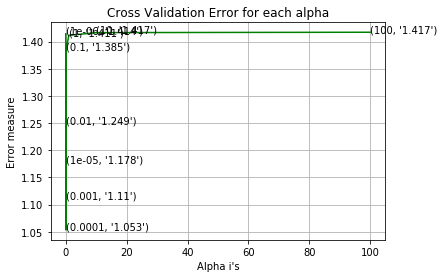

For values of best alpha =  0.0001 The train log loss is: 0.5094362949432157
For values of best alpha =  0.0001 The cross validation log loss is: 1.0533398381003063
For values of best alpha =  0.0001 The test log loss is: 1.064191191921312


In [52]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_count_11_5k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_count_11_5k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_count_11_5k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_count_11_5k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_count_11_5k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_count_11_5k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_count_11_5k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_count_11_5k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### LR_COUNT_TEXT_8K

In [53]:
from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=8000).fit(train_text_feature_onehotCoding_count_11,train_y)
train_text_feature_onehotCoding_count_11_8k_new=selectkbest1.transform(train_text_feature_onehotCoding_count_11)
test_text_feature_onehotCoding_count_11_8k_new=selectkbest1.transform(test_text_feature_onehotCoding_count_11)
cv_text_feature_onehotCoding_count_11_8k_new=selectkbest1.transform(cv_text_feature_onehotCoding_count_11)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_count_11_8k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_count_11_8k_new)).tocsr()

test_x_onehotCoding_count_11_8k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_count_11_8k_new)).tocsr()

cv_x_onehotCoding_count_11_8k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_count_11_8k_new)).tocsr()


for alpha = 1e-06
Log Loss : 1.3833033281745442
for alpha = 1e-05
Log Loss : 1.1474483094847605
for alpha = 0.0001
Log Loss : 1.0061127015462763
for alpha = 0.001
Log Loss : 1.0259291765759977
for alpha = 0.01
Log Loss : 1.2007540414166762
for alpha = 0.1
Log Loss : 1.4094013602190612
for alpha = 1
Log Loss : 1.4633035094404876
for alpha = 10
Log Loss : 1.4658297557131184
for alpha = 100
Log Loss : 1.4660286286280582


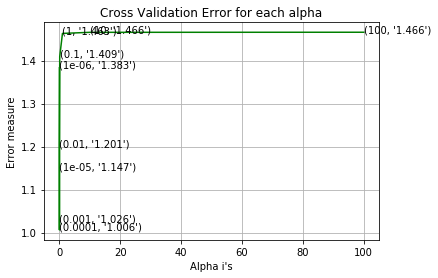

For values of best alpha =  0.0001 The train log loss is: 0.47370443883907437
For values of best alpha =  0.0001 The cross validation log loss is: 1.0061127015462763
For values of best alpha =  0.0001 The test log loss is: 1.0042807457733895


In [56]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_count_11_8k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_count_11_8k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_count_11_8k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_count_11_8k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_count_11_8k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_count_11_8k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_count_11_8k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_count_11_8k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### LR_COUNT_TEXT_10K

In [57]:
from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=10000).fit(train_text_feature_onehotCoding_count_11,train_y)
train_text_feature_onehotCoding_count_11_10k_new=selectkbest1.transform(train_text_feature_onehotCoding_count_11)
test_text_feature_onehotCoding_count_11_10k_new=selectkbest1.transform(test_text_feature_onehotCoding_count_11)
cv_text_feature_onehotCoding_count_11_10k_new=selectkbest1.transform(cv_text_feature_onehotCoding_count_11)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_count_11_10k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_count_11_10k_new)).tocsr()

test_x_onehotCoding_count_11_10k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_count_11_10k_new)).tocsr()

cv_x_onehotCoding_count_11_10k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_count_11_10k_new)).tocsr()


for alpha = 1e-06
Log Loss : 1.387162695556137
for alpha = 1e-05
Log Loss : 1.1573564295867251
for alpha = 0.0001
Log Loss : 1.0125887706902685
for alpha = 0.001
Log Loss : 1.0027267548150074
for alpha = 0.01
Log Loss : 1.1891549874582374
for alpha = 0.1
Log Loss : 1.4044944497669014
for alpha = 1
Log Loss : 1.45687615702701
for alpha = 10
Log Loss : 1.4598826030918568
for alpha = 100
Log Loss : 1.4601691046280119


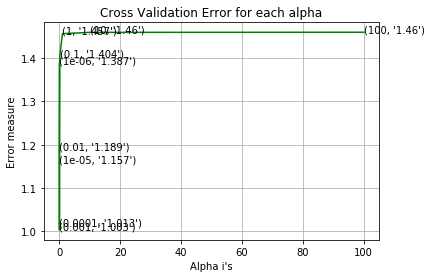

For values of best alpha =  0.001 The train log loss is: 0.6475277768127419
For values of best alpha =  0.001 The cross validation log loss is: 1.0027267548150074
For values of best alpha =  0.001 The test log loss is: 1.0231482743004405


In [58]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_count_11_10k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_count_11_10k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_count_11_10k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_count_11_10k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_count_11_10k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_count_11_10k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_count_11_10k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_count_11_10k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### LR_COUNT_TEXT_15K

In [60]:
from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=15000).fit(train_text_feature_onehotCoding_count_11,train_y)
train_text_feature_onehotCoding_count_11_15k_new=selectkbest1.transform(train_text_feature_onehotCoding_count_11)
test_text_feature_onehotCoding_count_11_15k_new=selectkbest1.transform(test_text_feature_onehotCoding_count_11)
cv_text_feature_onehotCoding_count_11_15k_new=selectkbest1.transform(cv_text_feature_onehotCoding_count_11)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_count_11_15k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_count_11_15k_new)).tocsr()

test_x_onehotCoding_count_11_15k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_count_11_15k_new)).tocsr()

cv_x_onehotCoding_count_11_15k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_count_11_15k_new)).tocsr()


for alpha = 1e-06
Log Loss : 1.4650462213932975
for alpha = 1e-05
Log Loss : 1.202215802680836
for alpha = 0.0001
Log Loss : 0.9939072675145622
for alpha = 0.001
Log Loss : 0.9994840001728699
for alpha = 0.01
Log Loss : 1.1747942811134717
for alpha = 0.1
Log Loss : 1.3940920011685516
for alpha = 1
Log Loss : 1.441904273224467
for alpha = 10
Log Loss : 1.4459608470898133
for alpha = 100
Log Loss : 1.4463903396899416


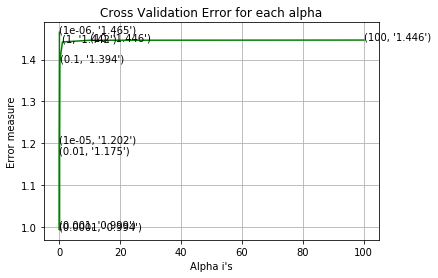

For values of best alpha =  0.0001 The train log loss is: 0.42480680999375453
For values of best alpha =  0.0001 The cross validation log loss is: 0.9939072675145622
For values of best alpha =  0.0001 The test log loss is: 0.9716127660423408


In [61]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_count_11_15k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_count_11_15k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_count_11_15k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_count_11_15k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_count_11_15k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_count_11_15k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_count_11_15k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_count_11_15k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [63]:
from sklearn.feature_selection import SelectKBest, chi2
selectkbest1=SelectKBest(score_func=chi2,k=50000).fit(train_text_feature_onehotCoding_count_11,train_y)
train_text_feature_onehotCoding_count_11_50k_new=selectkbest1.transform(train_text_feature_onehotCoding_count_11)
test_text_feature_onehotCoding_count_11_50k_new=selectkbest1.transform(test_text_feature_onehotCoding_count_11)
cv_text_feature_onehotCoding_count_11_50k_new=selectkbest1.transform(cv_text_feature_onehotCoding_count_11)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding_count_11_50k = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_count_11_50k_new)).tocsr()

test_x_onehotCoding_count_11_50k = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_count_11_50k_new)).tocsr()

cv_x_onehotCoding_count_11_50k = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_count_11_50k_new)).tocsr()


for alpha = 1e-06
Log Loss : 1.4242705883702436
for alpha = 1e-05
Log Loss : 1.2770120173128725
for alpha = 0.0001
Log Loss : 1.033321425800312
for alpha = 0.001
Log Loss : 1.036312484038279
for alpha = 0.01
Log Loss : 1.1526920430333778
for alpha = 0.1
Log Loss : 1.302682783579741
for alpha = 1
Log Loss : 1.3574725197203263
for alpha = 10
Log Loss : 1.3744285937664367
for alpha = 100
Log Loss : 1.3765517912604823


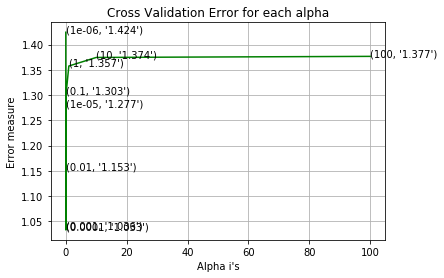

For values of best alpha =  0.0001 The train log loss is: 0.47530416353688054
For values of best alpha =  0.0001 The cross validation log loss is: 1.033321425800312
For values of best alpha =  0.0001 The test log loss is: 1.0282988627282426


In [64]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding_count_11_50k, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding_count_11_50k, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding_count_11_50k)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding_count_11_50k, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding_count_11_50k, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding_count_11_50k)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding_count_11_50k)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding_count_11_50k)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### SUMMARY:Here when i used Count vectorizer with 15k best features i got both test and Cv logloss less than 1

In [62]:
from prettytable import PrettyTable
    
P = PrettyTable()

P.field_names = ["model", "Text_featurization", "Best_alpha", "Min_test_loss"]

P.add_row(["Naive_bayes", "", 1000, 1.197])
P.add_row(["K-NN", "response_coding", 15, 1.09])
P.add_row(["Linear_regression_with_Classbalancing", "TfIdf", 0.001, 1.047])
P.add_row(["Linear_regression_without_Classbalancing", "TfIdf", 0.001, 1.059])
P.add_row(["LR_1_K", "Tfidf", 0.0001, 1.029])
P.add_row(["Linear_Svm", "Tfidf", 0.01, 1.06])
P.add_row(["Linear_svm", " Tfidf_2.8k_feat", 0.0002, 0.99])
P.add_row(["Rand_Forest", "Tfidf_response_coding", 2000,1.14])
P.add_row(["Rand_Forest", "Tfidf_one_ht", 2000,1.24])
P.add_row(["Rand_Forest_1K", "Tfidf_response_coding", 2000,1.242])
P.add_row(["Logistic_regression", "Count_vectorizer", 0.001,1.229])
P.add_row(["Logistic_regression_15k", "Count_vectorizer", 0.0001,0.97])



print(P)

+------------------------------------------+-----------------------+------------+---------------+
|                  model                   |   Text_featurization  | Best_alpha | Min_test_loss |
+------------------------------------------+-----------------------+------------+---------------+
|               Naive_bayes                |                       |    1000    |     1.197     |
|                   K-NN                   |    response_coding    |     15     |      1.09     |
|  Linear_regression_with_Classbalancing   |         TfIdf         |   0.001    |     1.047     |
| Linear_regression_without_Classbalancing |         TfIdf         |   0.001    |     1.059     |
|                  LR_1_K                  |         Tfidf         |   0.0001   |     1.029     |
|                Linear_Svm                |         Tfidf         |    0.01    |      1.06     |
|                Linear_svm                |     Tfidf_2.8k_feat   |   0.0002   |      0.99     |
|               Rand

# Conclusion:
###   1.Logistic regression and linear Svm are working well compared to other models
###   2.when we tried with 1k features of Tfidf the results are almost same
###   3.The minimum logloss which i got here is 0.99 with Linear Svm model and number of misclassified points are also minimum which is 0.4
